<a href="https://colab.research.google.com/github/Giuseppe86-lab/Cross-Selling-di-polizze-assicurative-/blob/main/Cross_selling_polizze_assicurative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Esplorazione del Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.base import clone
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold

In [ ]:
URL = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv'
df = pd.read_csv(URL, index_col=0)
print(df.shape)
df.head()

(381109, 11)


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In questo dataset abbiamo 381109 samples, 10 feature e una variabile target (**Response**)

1. **Gender**: variabile qualitativa categorica che indica il sesso del cliente.
2. **Age**: variabile quantitativa continua che indica l'età del cliente.
3. **Driving_License**: variabile qualitativa categorica che indica se il cliente possiede la patente.
4. **Region_Code**: variabile qualitativa categorica che indica la regione di residenza del cliente.
5. **Previously_Insured**: variabile qualitativa categorica che indica se il cliente ha già un veicolo assicurato.
6. **Vehicle_Age**: variabile qualitativa ordinale che indica l'età del veicolo.
7. **Vehicle_Damage**: variabile qualitativa categorica che indica se il cliente ha avuto incidenti o danni al veicolo in passato.
8. **Annual_Premium**: variabile quantitativa continua che indica l'importo annuale pagato dal cliente.
9. **Policy_Sales_Channel**: variabile qualitativa categorica che indica il canale utilizzato per la vendita.
10. **Vintage**: variabile quantitativa continua che indica da quanti giorni il cliente è assicurato con **AssurePredict**.
11. **Response**: variabile target che indica se il cliente ha accettato (1) o meno (0) la proposta, questo caratterizza il nostro problema come un problema di **classificazione**.

L'obiettivo del progetto è sviluppare un **modello di machine learning** che preveda se i clienti, che attualmente hanno una assicurazione saniataria, potrebbero essere intaressati a sottoscrivere una polizza assicurativa per il loro veicolo.


## 1.1 Caratteristiche generali del dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 34.9+ MB


Nel nostro dataset sono presenti feature di vario tipo:

- **int**: Age, Driving_License, Previously_Insured, Vintage, Response
- **float**: Region_Code, Annual_Premium, Policy_Sales_Channel
- **object**: Gender, Vehicle_Age, Vehicle_Damage

È importante andare a osservare il tipo delle feature perché in base alle loro caratteristiche e tipologie dovremmo svolgere delle diverse analisi esplorative. Le informazioni ottenute con *df.info()* ci dicono anche che nel nostro dataset non ci sono valori mancanti. Verifichiamo se ci sono sample duplicati:

In [ ]:
duplicate_rows = df.duplicated()

duplicates = df[df.duplicated()]
print(duplicates)

        Gender  Age  Driving_License  Region_Code  Previously_Insured  \
id                                                                      
35755     Male   23                1         15.0                   0   
41516     Male   39                1         30.0                   0   
43619     Male   40                1         28.0                   1   
44050     Male   39                1         28.0                   0   
44204     Male   44                1         28.0                   0   
...        ...  ...              ...          ...                 ...   
379274    Male   58                1         30.0                   1   
379452    Male   41                1         30.0                   0   
379789    Male   38                1         28.0                   1   
380674  Female   37                1         28.0                   0   
380719  Female   35                1         30.0                   1   

       Vehicle_Age Vehicle_Damage  Annual_Premium 

Nel nostro dataset ci sono un totale di 269 duplicati su 381109 ioè lo 0.07%, non potendo verificare la loro correttezza decido di eliminarli per pulire il dataset.

In [ ]:
df= df.drop_duplicates()

In [ ]:
df[['Age', 'Annual_Premium', 'Vintage']].describe()

,Age,Annual_Premium,Vintage
count,380840.000000,380840.000000,380840.000000
mean,38.823593,30584.016078,154.344607
std,15.513206,17203.258664,83.670240
min,20.000000,2630.000000,10.000000
25%,25.000000,24426.000000,82.000000
50%,36.000000,31678.500000,154.000000
75%,49.000000,39408.000000,227.000000
max,85.000000,540165.000000,299.000000


In [ ]:
df.describe(include='object')

,Gender,Vehicle_Age,Vehicle_Damage
count,380840,380840,380840
unique,2,3,2
top,Male,1-2 Year,Yes
freq,205938,200167,192277


In [ ]:
df['Region_Code'].value_counts().sort_index()

,count
Region_Code,
0.0,2015
1.0,1006
2.0,4037
3.0,9245
4.0,1798
5.0,1279
6.0,6277
7.0,3275
8.0,33857


Avendo 52 codici probabilmente ogni numero è associato ad uno Stato degli Stati Uniti d'America visto che il dataset sembra essere di quel paese.

In [ ]:
df['Policy_Sales_Channel'].value_counts().sort_index()

,count
Policy_Sales_Channel,
1.0,1074
2.0,4
3.0,523
4.0,509
6.0,3
...,...
157.0,6677
158.0,492
159.0,51


Le due feature **Region_Code** e **Policy_Sales_Channel** sono due categoriche con molti canali, avranno bisogno di una rappresentazione a parte per poter mettere in evidenza tutte le loro classi.

## 1.2 Analisi Univariata

In questa fase andiamo a studiare le distribuzioni delle singole feature.

Per le variabile categoriche realizziamo dei grafici a barre per vedere la distribuzione delle diverse classi, se sono o meno equamente rappresentate.

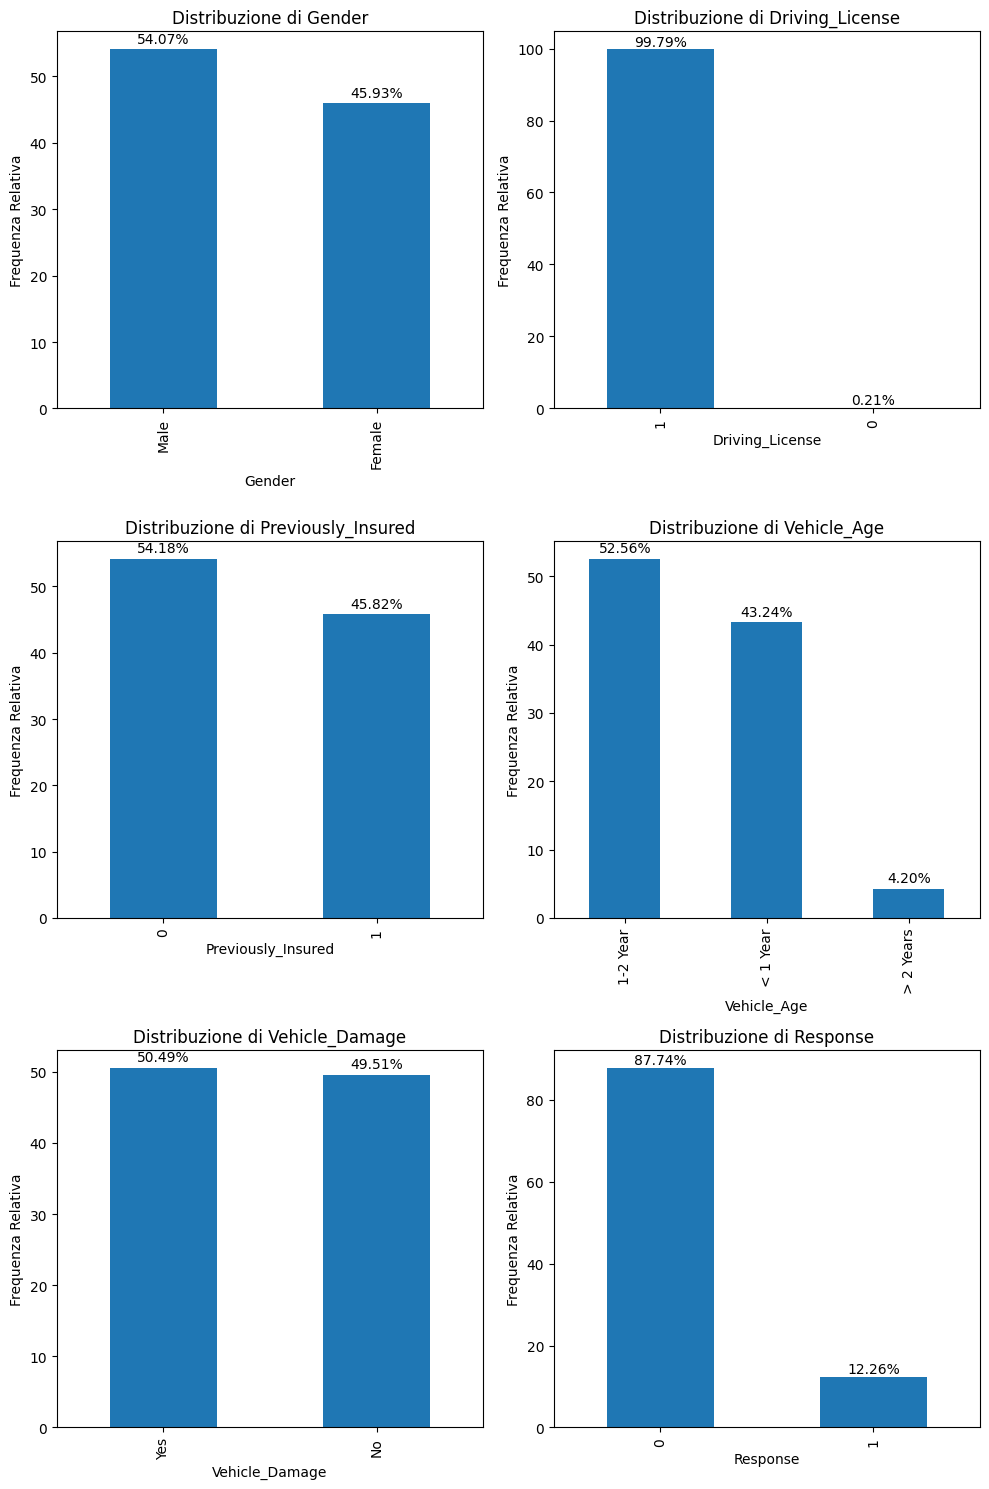

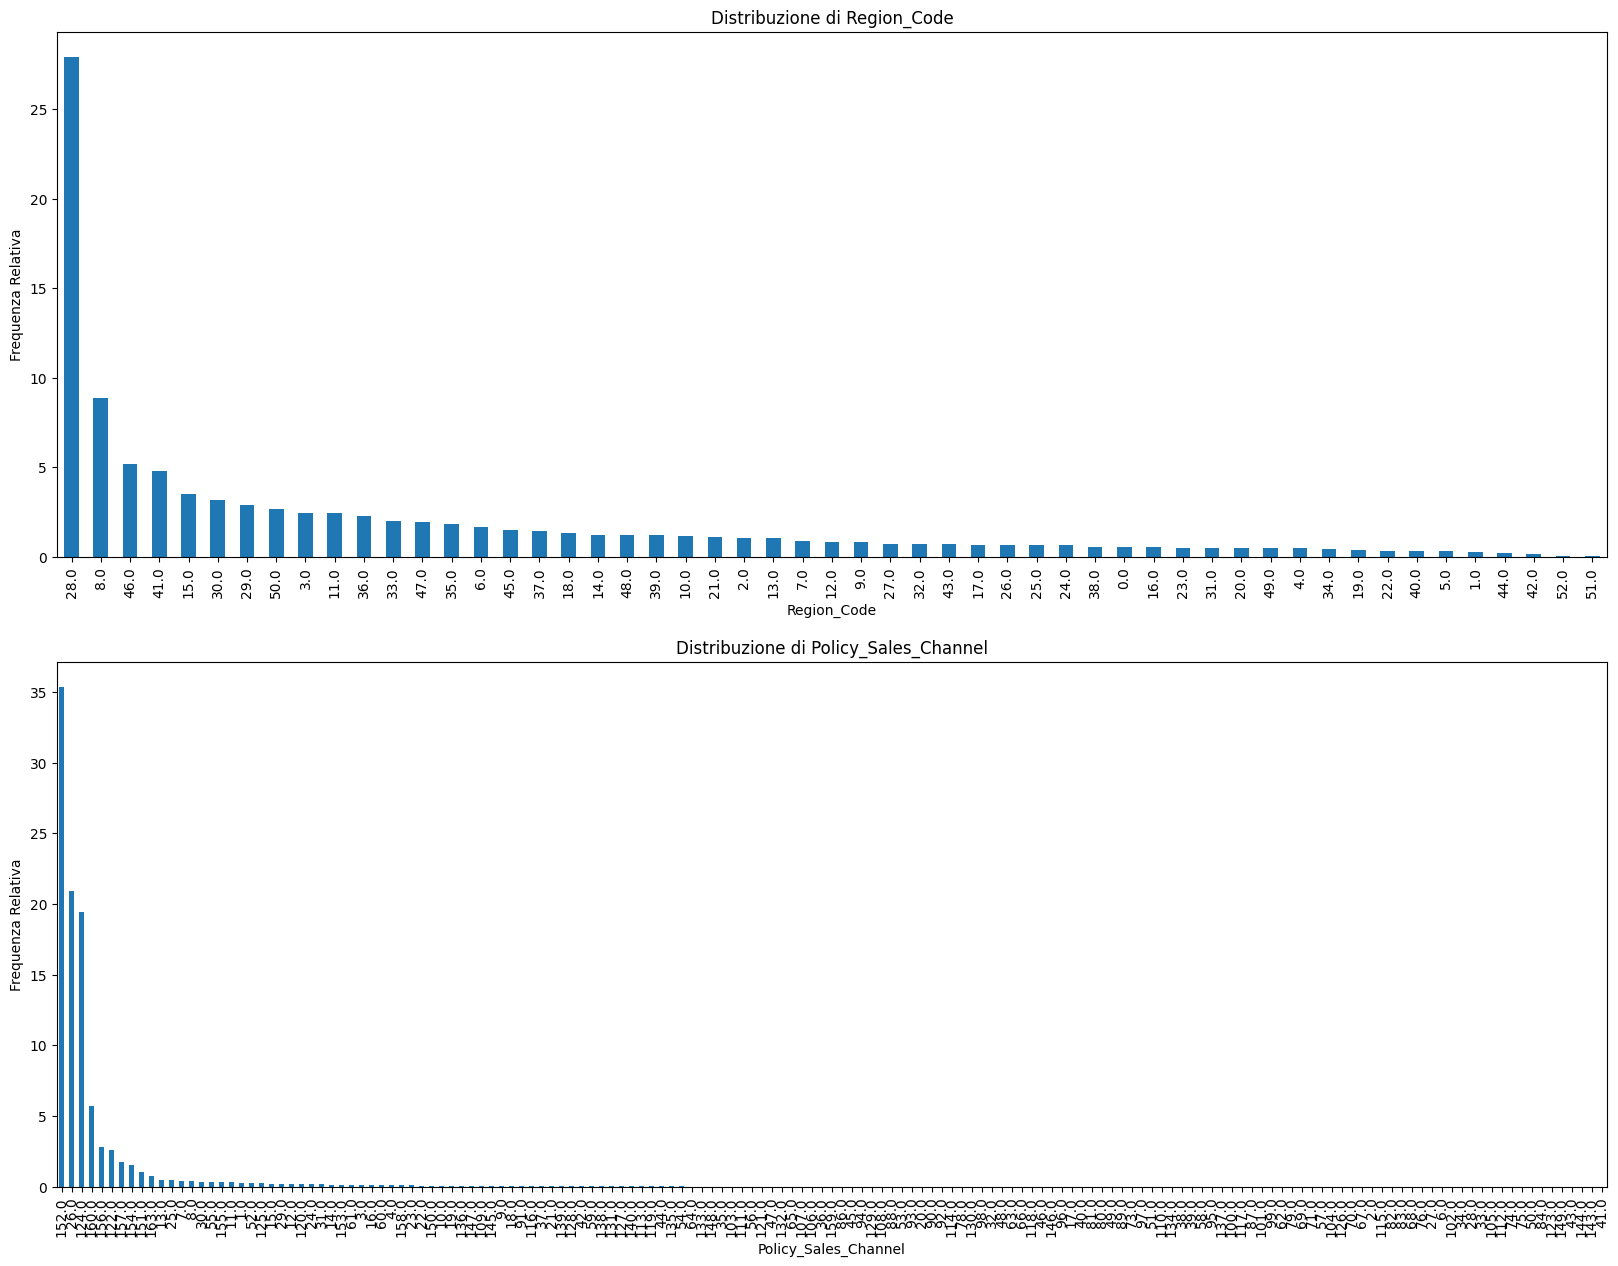

In [ ]:
columns=['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Response']
num_entries = df.shape[0]

fig, axes = plt.subplots(3, 2, figsize=(10, 15))
for i, column in enumerate(columns):
  row = i // 2
  col = i % 2
  counts_per = (df[column].value_counts()/num_entries)*100
  counts_per.plot(kind='bar', ax=axes[row, col])
  axes[row, col].set_title(f'Distribuzione di {column}')
  axes[row, col].set_xlabel(column)
  axes[row, col].set_ylabel('Frequenza Relativa')
  for i, value in enumerate(counts_per):
            axes[row, col].text(i, value + 1, f"{value:.2f}%", ha='center', fontsize=10)


plt.tight_layout()
plt.show()

columns_RC_PS = ['Region_Code', 'Policy_Sales_Channel']
fix, axes = plt.subplots(2,1, figsize=(20,15))
for i, column in enumerate(columns_RC_PS):
  counts_per = (df[column].value_counts()/num_entries)*100
  counts_per.plot(kind='bar', ax=axes[i])
  axes[i].set_title(f'Distribuzione di {column}')
  axes[i].set_xlabel(column)
  axes[i].set_ylabel('Frequenza Relativa')

Questi istogrammi ci permettono di cogliere alcune caratteristiche del nostro dataset:

- **Gender**: i due sessi sono quasi equamente rappresentati.
- **Driving License**: quasi la totalità dei clienti ha la patente.
- **Previously Insured**: il 54% dei clienti non ha un veicolo assicurato.
- **Vehicle Age**: il 94% dei clienti ha veicoli con meno di due anni.
- **Region Code**: ci dice che la classe modale è molto più presente delle altre con circa il 28%.
- **Policy Sales Channel**: ci dice che alcuni pochi canali sono quelli più usati.
- **Vehicle Damage**: il 50% dei clienti ha subito danni o commesso incidenti col proprio veicolo.
- **Response**: l'88% dei clienti non ha accettato di comprare una polizza assicurativa per la propria macchina.

Per le variabili continue realizziamo sia un istogramma che un boxplot:

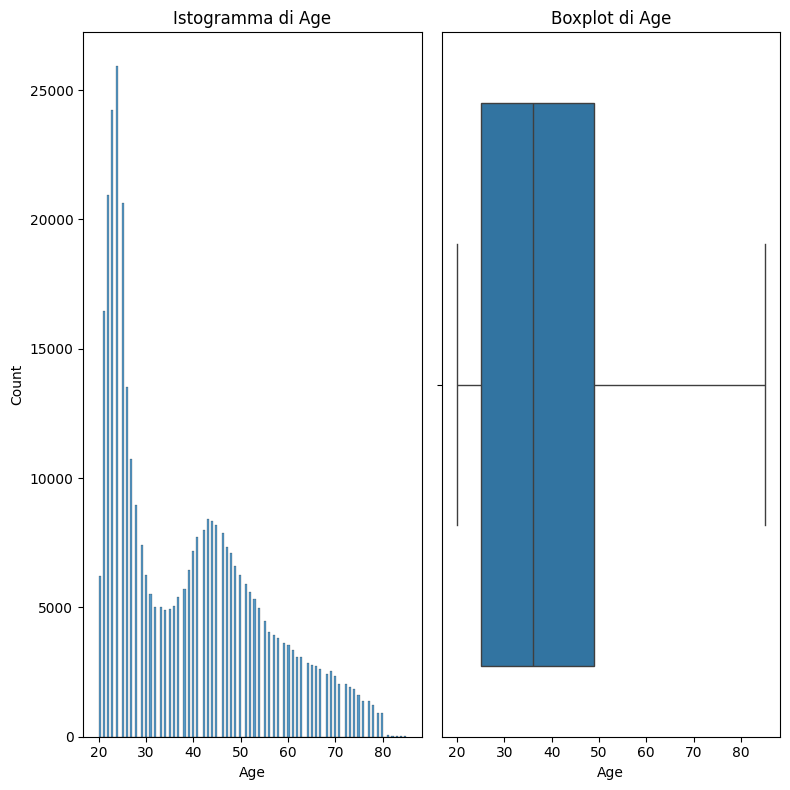

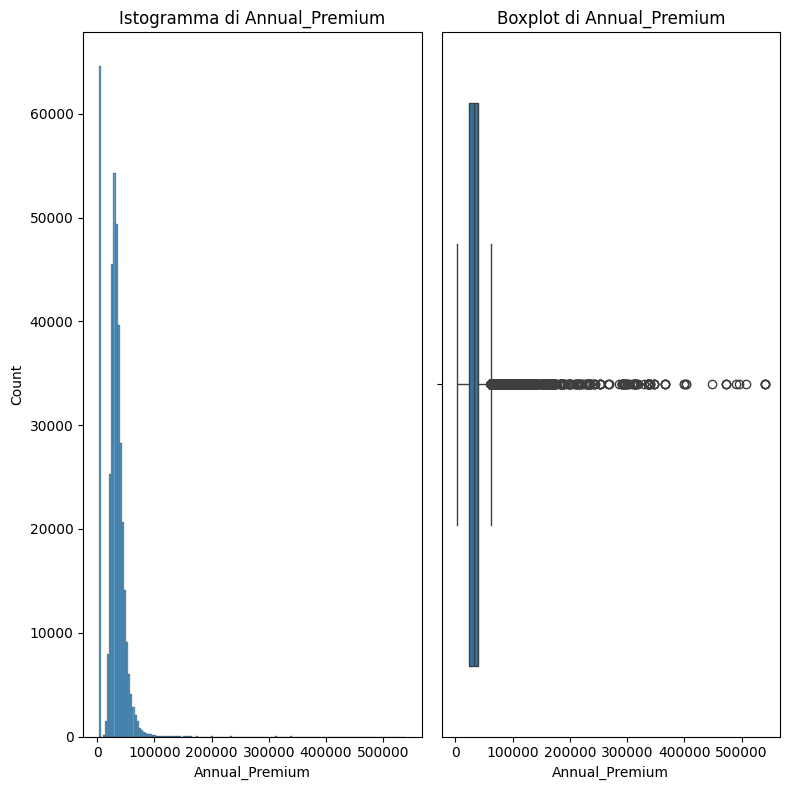

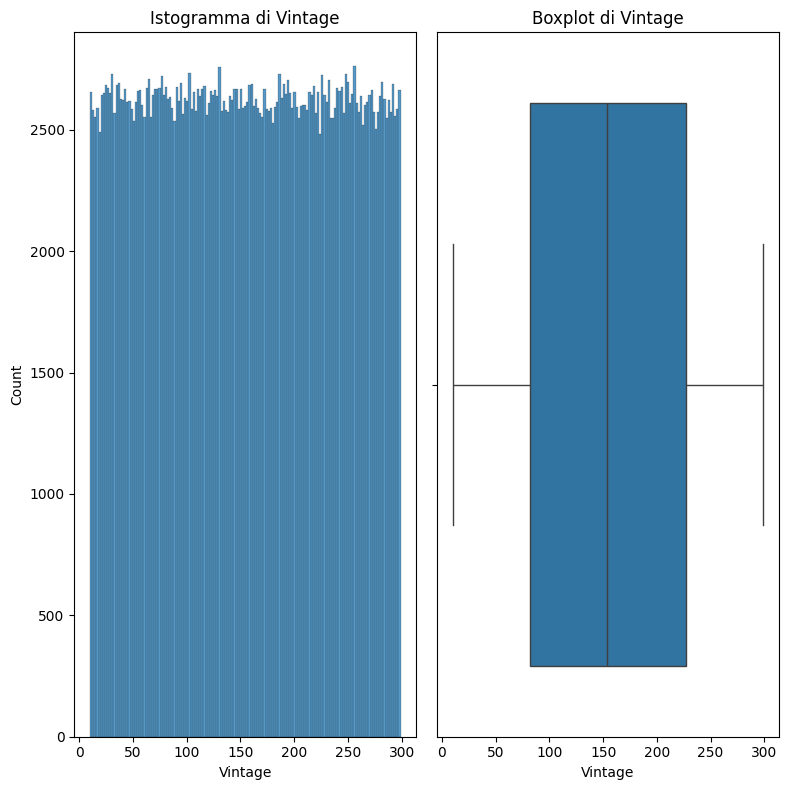

In [ ]:
columns = ['Age', 'Annual_Premium', 'Vintage']

for column in columns:
  fig, axes = plt.subplots(1, 2, figsize=(8, 8))
  sns.histplot(data=df, x=df[column], bins = 'rice', ax=axes[0])
  axes[0].set_title(f'Istogramma di {column}')

  sns.boxplot(data=df, x=df[column],
               ax=axes[1])
  axes[1].set_title(f'Boxplot di {column}')
  plt.tight_layout()
  plt.show()

I grafici delle variabili quantitative ci danno le seguenti informazioni:

- **Age**: la distribuzione ha due picchi uno principale tra 20-30 anni e uno secondario tra 40-50. Il boxplot non presenta outlier.
- **Annual Premium**: La distribuzione ha una coda a destra molto ampia infatti anche dal describe possiamo notare come il terzo percentile sia 39400 mentre il massimo sia 540165.
- **Vintage**: la distribuzione è sostanzialmente piatta segno che sono stati raccolti campioni distribuiti uniformemente per quanto riguarda questa feature, vedremo nel confronto col target se questo è un segno di poca significatività della variabile stessa.

## 1.3 Analisi Multivariata per feature quantitative

Studio delle relazioni delle feature tra di loro e con il target.

Analizziamo prima le feature quantitative continue per cercare eventuali correlazioni:

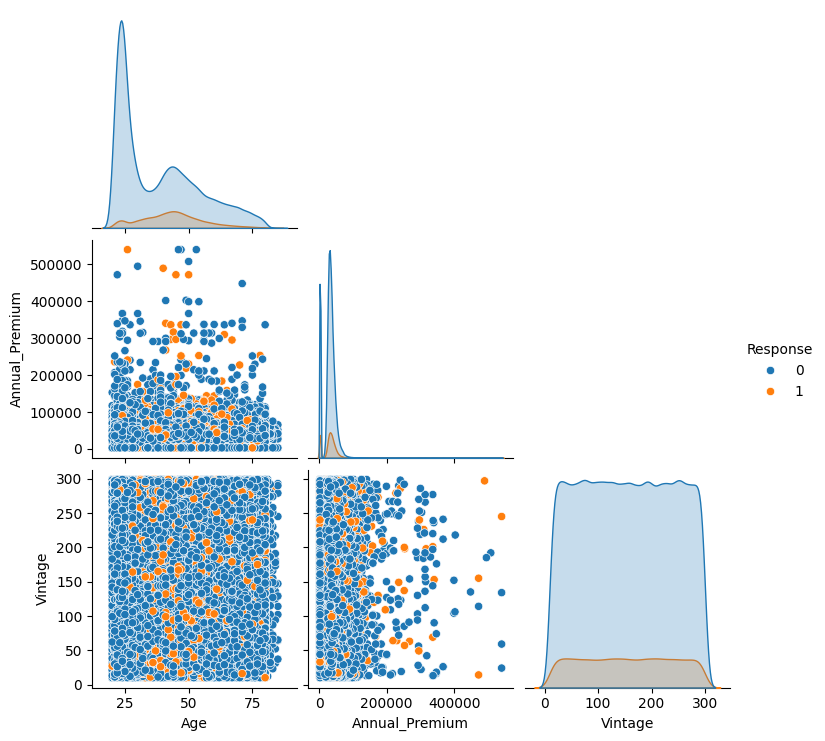

In [ ]:
df_cont = df[['Age', 'Annual_Premium','Vintage','Response']]
sns.pairplot(df_cont, hue='Response', corner=True)

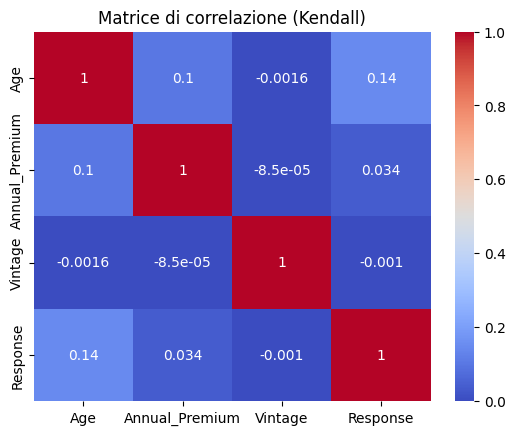

In [ ]:
columns_of_interest = ['Age', 'Annual_Premium', 'Vintage', 'Response']
df_corr = df[columns_of_interest]
correlation_matrix = df_corr.corr(method='spearman')

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matrice di correlazione (Kendall)")
plt.show()

Questi grafici e la matrice di correlazione mostano che tra le feature c'è una sostanziale assenza di correlazione, **Age** sembra quella che ha una relazione più forte con il target.

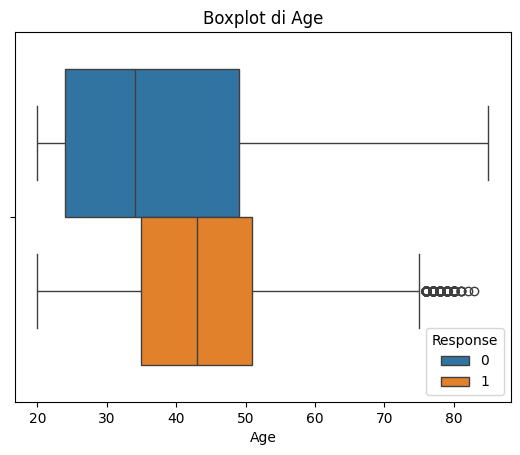

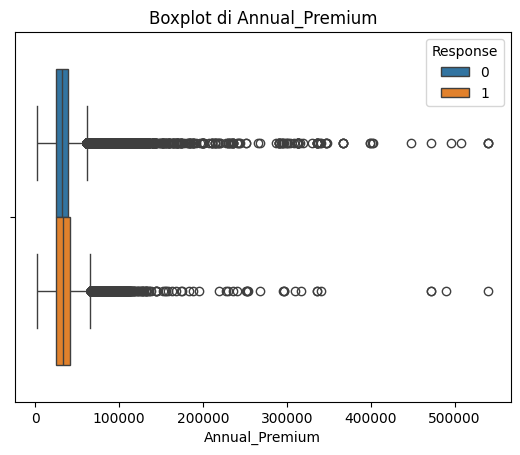

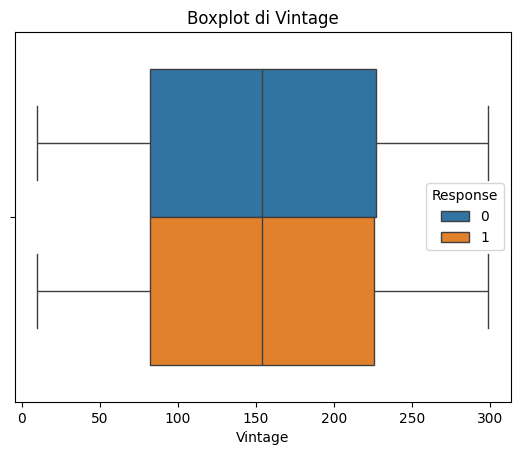

In [ ]:
columns = ['Age', 'Annual_Premium', 'Vintage']

for column in columns:
  sns.boxplot(data=df, x=df[column], hue='Response')
  plt.title(f'Boxplot di {column}')
  plt.show()

### 1.3.A Test statistici su feature quantitative

Dai tre boxplot sembrerebbe che **Age** e **Annual Premium** mostrino una dipendenza dalla variabile target. Dobbiamo verificare se queste differenze sono statisticamente significative, facciamo questa verifica anche per **Vintage** come ulteriore verifica del dato visivamente osservato.

Usiamo il Mann-Whitney U test in quanto le distribuzioni non verificano l'ipotesi di normalità, quindi un t-test potrebbe dare risultati non adeguati. In questo test l'ipotesi H0 è che i due campioni provengano dalla stessa distribuzione.

In [ ]:
from scipy.stats import mannwhitneyu

columns = ['Age', 'Annual_Premium', 'Vintage']

for col in columns:

  group1 = df[df['Response'] == 0][col]
  group2 = df[df['Response'] == 1][col]

# Mann-Whitney U Test
  stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
  print(f"{col}: Mann-Whitney U Test: p-value = {p_value}")

  if p_value < 0.05:
      print(f"{col} dipende significativamente da Response.\n")
  else:
      print(f"Non c'è evidenza che {col} dipenda da Response.\n")


Age: Mann-Whitney U Test: p-value = 0.0
Age dipende significativamente da Response.

Annual_Premium: Mann-Whitney U Test: p-value = 2.319943559689334e-97
Annual_Premium dipende significativamente da Response.

Vintage: Mann-Whitney U Test: p-value = 0.5222125716438006
Non c'è evidenza che Vintage dipenda da Response.



Il risultato del test conferma che c'è una dipendenza da **Response** sia per quanto riguarda l'età (chi ha accettato la proposta ha una età statisticamente maggiore di chi non l'ha accettata) che per quanto riguarda il premio annuale.

## 1.4 Analisi Multivariata per feature qualitative

Per rappresentare il legame con il target di ogni singola classe usiamo il barplot con le barre normalizzate a uno.

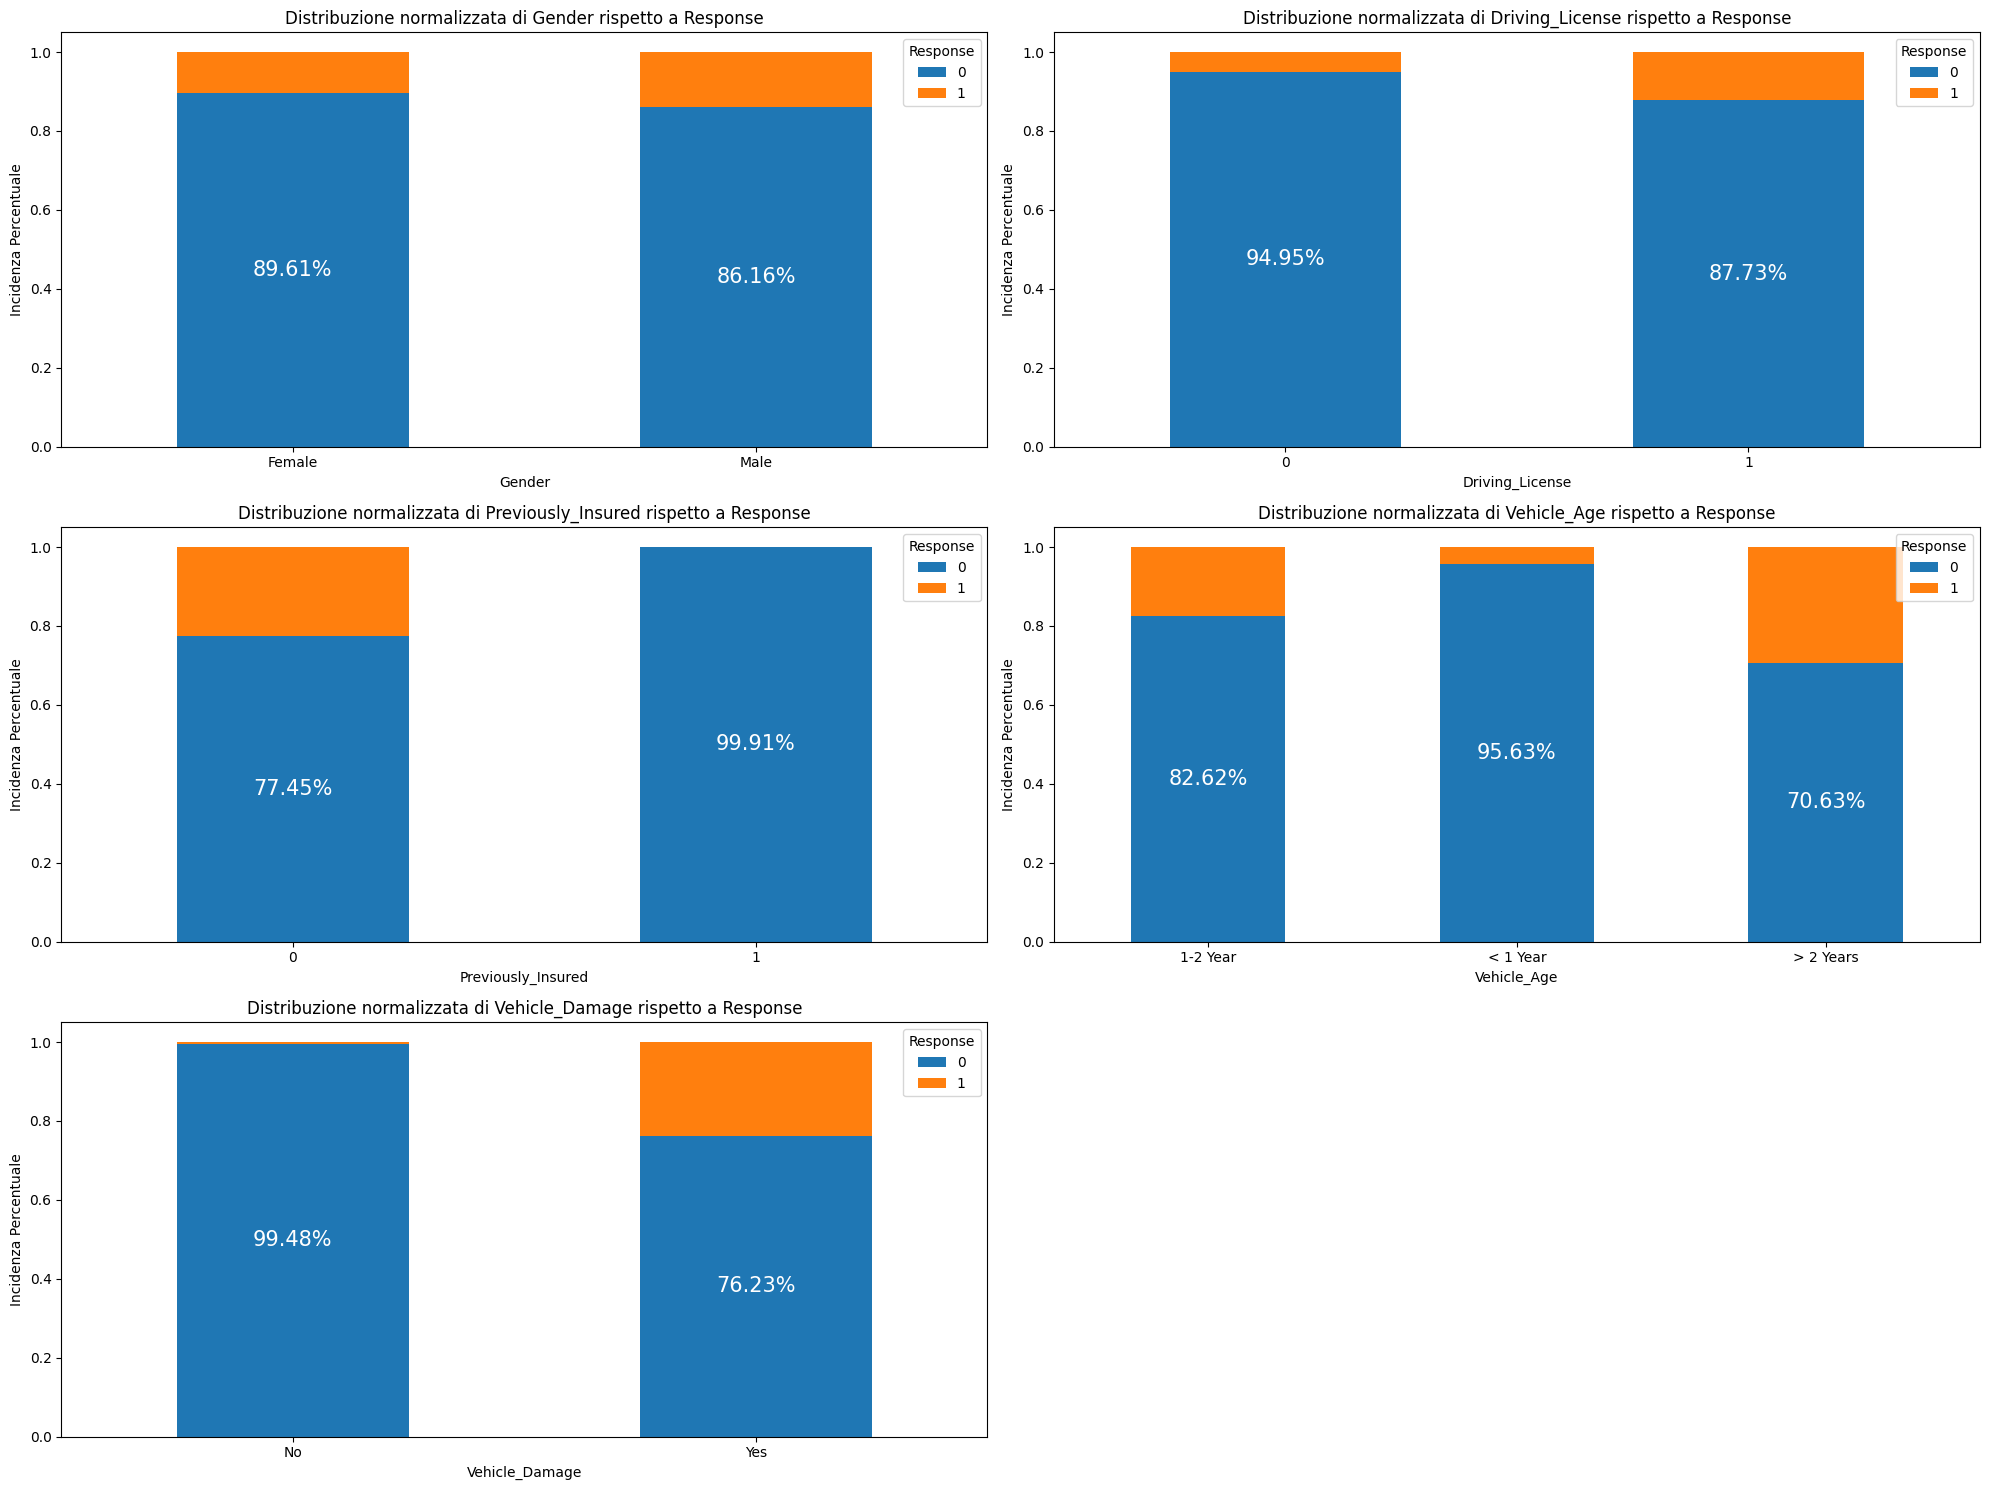

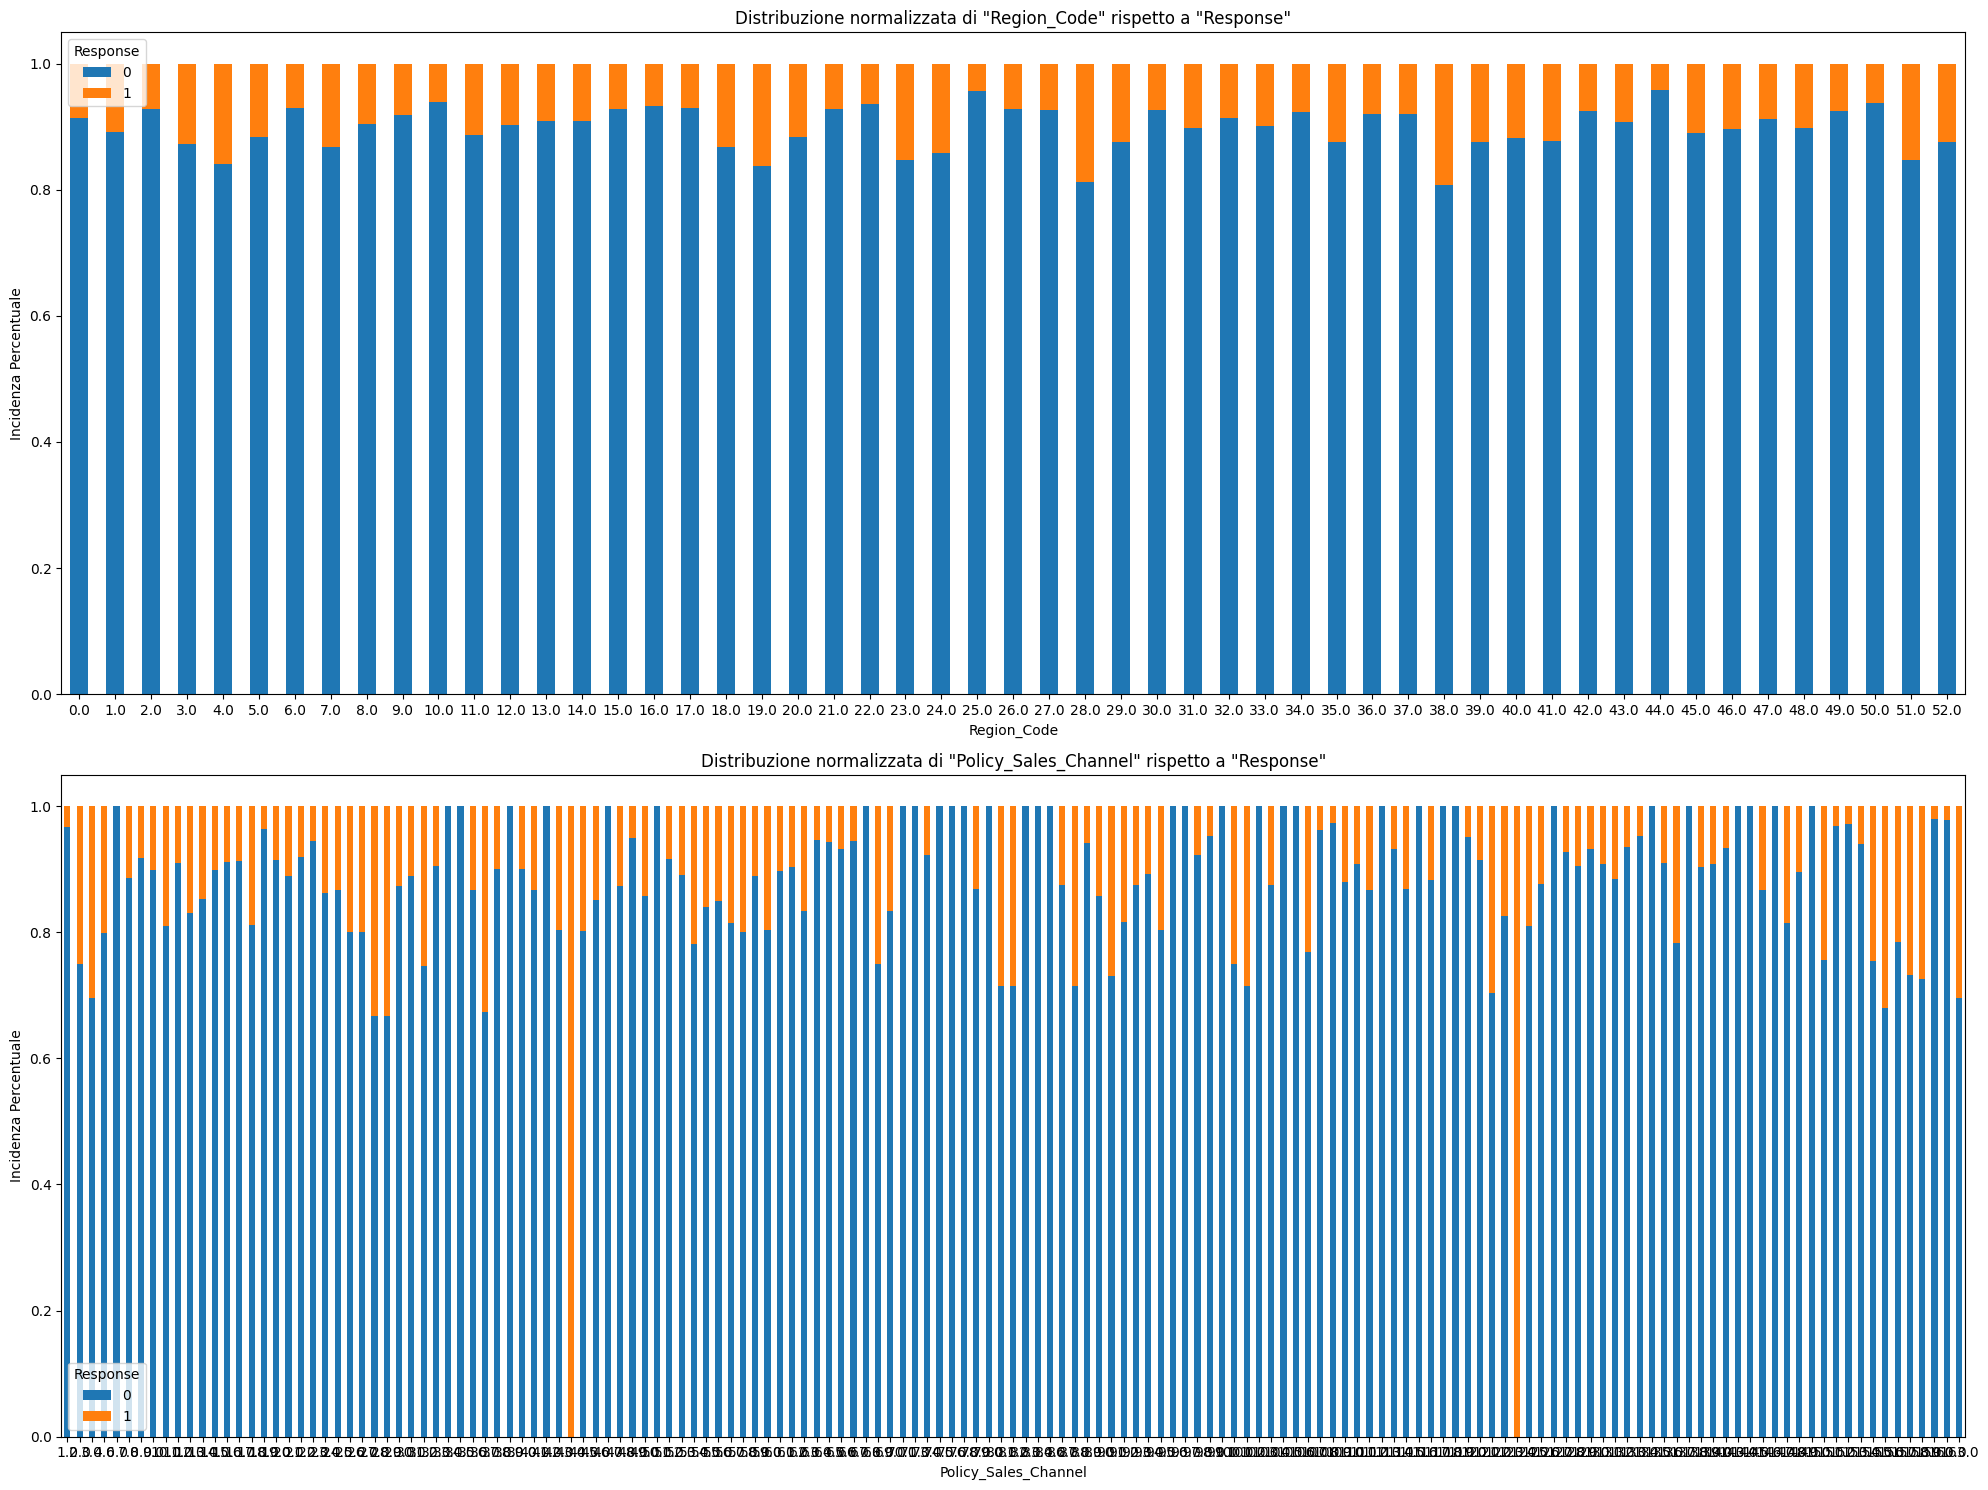

In [ ]:
columns = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']

fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.ravel()

for i, col in enumerate(columns):

    contingency_table = pd.crosstab(df[col], df['Response'])

    contingency_table_normalized = contingency_table.div(contingency_table.sum(axis=1), axis=0)

    bars = contingency_table_normalized.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'Distribuzione normalizzata di {col} rispetto a Response')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Incidenza Percentuale')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)
    axes[i].legend(title='Response')

    for bar_group, label in zip(bars.containers, contingency_table.columns):
        if label == 0:
            for bar in bar_group:
                height = bar.get_height()
                if height > 0:
                    x_pos = bar.get_x() + bar.get_width() / 2
                    axes[i].text(
                        x=x_pos,
                        y=height / 2,
                        s=f"{height:.2%}",
                        ha='center',
                        va='center',
                        fontsize=15,
                        color='white'
                    )


if len(columns) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

columns_RC_PS = ['Region_Code', 'Policy_Sales_Channel']
fix, axes = plt.subplots(2,1, figsize=(20,15))
for i, col in enumerate(columns_RC_PS):
  contingency_table = pd.crosstab(df[col], df['Response'])

  contingency_table_normalized = contingency_table.div(contingency_table.sum(axis=1), axis=0)

  contingency_table_normalized.plot(kind='bar', stacked=True, ax=axes[i])
  axes[i].set_title(f'Distribuzione normalizzata di "{col}" rispetto a "Response"')
  axes[i].set_xlabel(col)
  axes[i].set_ylabel('Incidenza Percentuale')
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)
  axes[i].legend(title='Response')


plt.tight_layout()
plt.show()

Questi grafici sono molto interessanti perché ci mostrano come tutte le classi sono popolate e in tutte le classi sono presenti clienti che hanno accettato la proposta.

Notiamo anche che chi non ha avuto il veicolo danneggiato al 99,5% risponderà di no alla proposta e chi è già assicurato al 99,9%.

### 1.4.A Test statistici su feature qualitative

Anche in questo caso svolgiamo dei test statistici (chi-quadro) per verificare quanto osservato dai nostri istogrammi.

In [ ]:
from scipy.stats import chi2_contingency

columns = ['Gender','Previously_Insured', 'Vehicle_Age',
          'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Driving_License']

for col in columns:
    contingency_table = pd.crosstab(df[col], df['Response'])

    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print(f"Feature: {col}")
    print(f"p-value: {p_value:}")

    if p_value < 0.05:
        print(f"\n Esiste un'associazione significativa tra '{col}' e 'Response' (p < 0.05).")
    else:
        print(f"\n Non c'è evidenza di un'associazione significativa tra '{col}' e 'Response' (p >= 0.05).")
    print("-" * 50)

Feature: Gender
p-value: 5.3788975019355325e-230

 Esiste un'associazione significativa tra 'Gender' e 'Response' (p < 0.05).
--------------------------------------------------
Feature: Previously_Insured
p-value: 0.0

 Esiste un'associazione significativa tra 'Previously_Insured' e 'Response' (p < 0.05).
--------------------------------------------------
Feature: Vehicle_Age
p-value: 0.0

 Esiste un'associazione significativa tra 'Vehicle_Age' e 'Response' (p < 0.05).
--------------------------------------------------
Feature: Vehicle_Damage
p-value: 0.0

 Esiste un'associazione significativa tra 'Vehicle_Damage' e 'Response' (p < 0.05).
--------------------------------------------------
Feature: Region_Code
p-value: 0.0

 Esiste un'associazione significativa tra 'Region_Code' e 'Response' (p < 0.05).
--------------------------------------------------
Feature: Policy_Sales_Channel
p-value: 0.0

 Esiste un'associazione significativa tra 'Policy_Sales_Channel' e 'Response' (p < 0.05).
-

Il test del chi-quadro ci restituisce che le feature considerate hanno un'associazione significativa con **Response**.

Questa fase di analisi descrittiva ci ha permesso di osservare come tutte le nostre features sono portatrici d'informazione esclusa **Vintage** il cui test del t-student non ci ha fatto rigettare l'ipotesi nulla.

Per quanto riguarda le 3 feature segnalate dal cliente come significative abbiamo determinato come per premi annuali più alti sia maggiore la probabilità di acquistare la nuova polizza, lo stesso dicasi per l'età del veicolo, mentre chi ha gia un veicolo assicurato al 99,9% rifiuterà la proposta.

# 2. Costruzione del modello predittivo

## 2.1 Gestione di Region_Code e Policy_Sales_Channel

Queste due feauter hanno molti canali ma solo pochi hanno una frequenza relativa superiore al 5% (5 per Policy_Sale_Channel e 3 per Region_Code), vale la pena definire quindi una classe **Rare** per diminuire i valori assunti e poi eseguire il OneHotEncoding viste che sono variabili qualitative non ordinali.

Svolgere direttamente il OHE farebbe esplodere il numero delle features rendendo più difficoltosa la convergenza del modello.

Le nuove feature prodotte con il OHE andranno a sostituire quelle originali.

Facciamo una copia del dataset originale su cui andremo ad eseguire le trasformazioni di preparazione per i nostri modelli.

In [ ]:
threshold = 0.05
columns = ['Policy_Sales_Channel','Region_Code']
for col in columns:
  freq = df[col].value_counts(normalize=True)
  rare_categories = freq[freq<threshold].index
  new_col = col+"_Grouped"
  df[new_col] = df[col].apply(
    lambda x: 'Rare' if x in rare_categories else x)

In [ ]:
print(df['Policy_Sales_Channel_Grouped'].value_counts())
print('-----------------------------')
print(df['Region_Code_Grouped'].value_counts())

Policy_Sales_Channel_Grouped
152.0    134680
26.0      79646
124.0     73928
Rare      70817
160.0     21769
Name: count, dtype: int64
-----------------------------
Region_Code_Grouped
Rare    220901
28.0    106335
8.0      33857
46.0     19747
Name: count, dtype: int64


In [ ]:
dummies_policy = pd.get_dummies(df['Policy_Sales_Channel_Grouped'], prefix = 'Channel')
dummies_region = pd.get_dummies(df['Region_Code_Grouped'], prefix = 'Code')
df_pr = df.copy()
df_pr = pd.concat([df_pr, dummies_policy, dummies_region], axis=1)
df_pr.drop(['Policy_Sales_Channel','Region_Code','Policy_Sales_Channel_Grouped', 'Region_Code_Grouped'], axis=1, inplace=True)
df_pr.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,Channel_26.0,Channel_124.0,Channel_152.0,Channel_160.0,Channel_Rare,Code_8.0,Code_28.0,Code_46.0,Code_Rare
id,,,,,,,,,,,,,,,,,,
1,Male,44,1,0,> 2 Years,Yes,40454.0,217,1,True,False,False,False,False,False,True,False,False
2,Male,76,1,0,1-2 Year,No,33536.0,183,0,True,False,False,False,False,False,False,False,True
3,Male,47,1,0,> 2 Years,Yes,38294.0,27,1,True,False,False,False,False,False,True,False,False
4,Male,21,1,1,< 1 Year,No,28619.0,203,0,False,False,True,False,False,False,False,False,True
5,Female,29,1,1,< 1 Year,No,27496.0,39,0,False,False,True,False,False,False,False,False,True


## 2.2 Preprocessing: Mapping feature, Spliting del dataset, Standardizzazione

In [ ]:
map_gender = {"Male":1, "Female":0}
df_pr["Gender"] = df_pr["Gender"].map(lambda x: map_gender[x])

map_vehicle_age = {"< 1 Year": 0, "1-2 Year": 1, "> 2 Years":2}
df_pr["Vehicle_Age"] = df_pr["Vehicle_Age"].map(lambda x: map_vehicle_age[x])

map_vehicle_damage = {"No": 0, "Yes": 1}
df_pr["Vehicle_Damage"] = df_pr["Vehicle_Damage"].map(lambda x: map_vehicle_damage[x])

df_pr.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response,Channel_26.0,Channel_124.0,Channel_152.0,Channel_160.0,Channel_Rare,Code_8.0,Code_28.0,Code_46.0,Code_Rare
id,,,,,,,,,,,,,,,,,,
1,1,44,1,0,2,1,40454.0,217,1,True,False,False,False,False,False,True,False,False
2,1,76,1,0,1,0,33536.0,183,0,True,False,False,False,False,False,False,False,True
3,1,47,1,0,2,1,38294.0,27,1,True,False,False,False,False,False,True,False,False
4,1,21,1,1,0,0,28619.0,203,0,False,False,True,False,False,False,False,False,True
5,0,29,1,1,0,0,27496.0,39,0,False,False,True,False,False,False,False,False,True


Svolgiamo la divisione del dataset in Train e Test, il train servirà per allenare i modelli; il Test per verificare la capacità del modello scelto di fare predizioni su dati non visti.

In [ ]:
RANDOM_SEED = 42

X = df_pr.drop(['Response', 'Vintage'], axis=1).values
y = df_pr["Response"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=RANDOM_SEED)
print(X_train.shape)
print(X_test.shape)

(266588, 16)
(114252, 16)


Verifichiamo che X_train e X_test siano campioni rappresentativi del dataset, cioè che abbiano le stesse caratteristiche, per questo scopo usiamo il test di Kolmogorov-Smirnov:

In [ ]:
from scipy.stats import ks_2samp

stat, p_value = ks_2samp(X_train.flatten(), X.flatten())

print("Verifica distribuzione per X_train")
print(f"Statistiche K-S: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Rifiutiamo l'ipotesi nulla: le distribuzioni sono diverse.\n")
else:
    print("Non rifiutiamo l'ipotesi nulla: le distribuzioni sono uguali.\n")


stat, p_value = ks_2samp(X_test.flatten(), X.flatten())
print("\nVerifica distribuzione per X_test")
print(f"Statistiche K-S: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Rifiutiamo l'ipotesi nulla: le distribuzioni sono diverse.\n")
else:
    print("Non rifiutiamo l'ipotesi nulla: le distribuzioni sono uguali.\n")


Verifica distribuzione per X_train
Statistiche K-S: 0.0001
P-value: 1.0000
Non rifiutiamo l'ipotesi nulla: le distribuzioni sono uguali.


Verifica distribuzione per X_test
Statistiche K-S: 0.0001
P-value: 1.0000
Non rifiutiamo l'ipotesi nulla: le distribuzioni sono uguali.



Abbiamo verificato che X_train e X_test sono due campioni coerenti con il dataset originale.

Svolgiamo la standardizzazione del nostro dataset, fondamentale per modelli che usano la LogisticRegression, feature su scale diverse potrebbero essere maleinterpretate dagli algoritmi.

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## 2.2 Creazione classe LogisticRegressionPipeline

In questa classe viene inizializato il modello e sono definiti tutti i metodi necessari alla nostra analisi:

LogisticRegressionPipeline
- fit
- predict_proba
- predict
- find_best_th_C
- cross_validation
- plot_rocCurve
- create_report
- plot_confusion_matrix

La classe ha anche i seguenti attributi:
- penalty
- C
- class_weight
- max_iter
- n_jobs
- threshold
- report
- model

Quando la classe vieni inizializzata, inizializza anche il modello di regressione logistica con i paramentri passati nell'istanza della classe.

In [ ]:
class LogisticRegressionPipeline:
  """
  This Class defines the operations that can be done to create and analyze the
  ML model, this Class is specific for Logistic Regression.
  """
  def __init__(self, penalty, C, class_weight, threshold = 0.5, solver = 'saga',
               max_iter = 1000, n_jobs = -1):
    """
      Initialize the LogisticRegressionPipeline instance.

      Methods:
      - fit(self, X, y, model=None)
      - predict_proba(self, X, model=None)
      - predict(self, y_probs, threshold = None)
      - find_best_th_C(self, X_train, y_train,
                     thr_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10],
                     noprint = True)
      - evaluate_metrics(self, X_train, y_train, X_test = None, y_test=None, threshold = None, model = None)
      - cross_validation(self, X_train, y_train, threshold = None)
      - plot_rocCurve(self, X_train, y_train)
      - create_report(self, X, y)
      - plot_confusion_matrix(self, X, y_true, labels=["Negative", "Positive"], show_precisione_recall=False)


      Arguments:
      - penalty (str): two values: 'l1' o 'l2'.
      - C (float): inverse of regolarization parameter.
      - class_weight (str): two values: None or 'balanced' for unbalanced dataset.
      - solver (str): 'saga' defines the solver.
      - max_iter (int): number of max iteration.
      - n_jobs (int): -1 to use all the CPU available.
      - threshold (float): threshold between 0 and 1 class.
      - report (dict): to save all the metrics of the model.
      - model: create the LogisticRegression model.
      """
    self.penalty = penalty
    self.C = C
    self.class_weight = class_weight
    self.solver = solver
    self.max_iter = max_iter
    self.n_jobs = n_jobs
    self.threshold = threshold
    self.report = {}
    self.model = LogisticRegression(penalty=self.penalty, C=self.C,
                                    class_weight = self.class_weight, solver = self.solver,
                                    max_iter = self.max_iter, n_jobs = self.n_jobs)

  def fit(self, X, y, model=None):
    '''
    If model=None use the class model to do the fit, otherwise use
    the one passed with the function call.

    Arguments:
    - X(ndarray): it contains the values of the features.
    - y(ndarray): it contains the values of the target.
    - model: LogisticRegression model
    '''
    if model is None:
        model = self.model

    model.fit(X, y)

  def predict_proba(self, X, model=None):
    '''
    If model=None use the class model to do calculate the probabilities, otherwise use
    the one passed with the function call. It returns the values of the probability
    for each sample.

    Arguments:
    - X(ndarray): it contains the values of the features.
    - model: LogisticRegression model
    '''
    if model is None:
        model = self.model

    return model.predict_proba(X)[:,1]

  def predict(self, y_probs, threshold = None):
    '''
    If threshold = None use the class value to evaluate the class of each sample.
    It returns an one dimensional vector with 0 o 1 for the prediction on each sample.

    Arguments:
    - y_probs(ndarray): it contains a column vector with the probabilities of the class 1.
    - threshold(float): the value to decide the class of the sample.
    '''
    threshold = threshold if threshold is not None else self.threshold
    return (y_probs >= threshold).astype(int)

  def find_best_th_C(self, X_train, y_train,
                     thr_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10],
                     noprint = True):
    '''
    This method searches for the best pair of threshold value and C value among those passed.
    The best pair is the one that obtains the highest value for the metric F1. This
    search is carried out through a double for loop and the evaluation of the above
    metric.

    Arguments:
    - X_train (ndarray): it contains the values of the features.
    - y_train (ndarray): - y(ndarray): it contains the values of the target.
    - thr_values (list): values from which to search for the optimal threshold.
    - C_values (list): values from which to search for the optimal regolarizzation parameter.
    - noprint (bool): if it is true, there is no printing of intermediate results.
    '''
    best_f1 = 0
    best_th = 0
    best_C = 0

    for C in C_values:
      model_C_th = LogisticRegression(penalty=self.penalty, C=C,
                                    class_weight = self.class_weight, solver = self.solver,
                                    max_iter = self.max_iter, n_jobs = self.n_jobs)
      model_C_th.fit(X_train, y_train)
      for th in thr_values:

        th_metrics = self.evaluate_metrics(X_train, y_train, threshold = th, model = model_C_th)

        if noprint == False:
          print(f"\nC = {C} - Threshold = {th}")
          print("Metrics:")
          for dataset_type, metrics_dict in th_metrics.items():
            print(f"  {dataset_type.capitalize()} Metrics:")
            print("    " + ", ".join(f"{metric_name}: {metric_value:.2f}" for metric_name, metric_value in metrics_dict.items()))
          print("---------------------")

        if th_metrics['train']['f1'] > best_f1:
          best_f1 = th_metrics['train']['f1']
          best_th = th
          best_C = C

    self.threshold = best_th
    self.C = C
    print(f'\n Valore più alto di f1 ({best_f1:.2f}) \n soglia: {best_th}')
    print(f'C(inverso indice di regolarizzazione):{best_C}\n')
    return best_C, best_th

  def evaluate_metrics(self, X_train, y_train, X_test = None, y_test=None, threshold = None, model = None):
    '''
    This function allows the calculation of metrics (F1, Precision and Recall)
    for both the training and test datasets. If no
    the threshold and model values, those already saved in the
    class.

    Arguments:
    - X_train (ndarray): it contains the values of the features (train dataset).
    - y_train (ndarray): it contains the values of the target (train dataset).
    - X_test (ndarray): it contains the values of the features (test dataset).
    - y_test (ndarray): it contains the values of the target (test dataset).
    - threshold (float): the value to decide the class of the sample.
    - model: LogisticRegression model
    '''
    if model is None:
        model = self.model

    threshold = threshold if threshold is not None else self.threshold

    y_probs_train = self.predict_proba(X_train, model)
    y_pred_train = self.predict(y_probs_train, threshold)
    metrics = {}
    metrics['train'] = {
        'precision': round(precision_score(y_train, y_pred_train, zero_division=0),2),
        'recall': round(recall_score(y_train, y_pred_train, zero_division=0),2),
        'f1': round(f1_score(y_train, y_pred_train, zero_division=0),2)
    }
    if X_test is not None:

      y_probs_test = self.predict_proba(X_test, model)
      y_pred_test = self.predict(y_probs_test, threshold)
      metrics['test'] = {
          'precision': round(precision_score(y_test, y_pred_test, zero_division=0),2),
          'recall': round(recall_score(y_test, y_pred_test, zero_division=0),2),
          'f1': round(f1_score(y_test, y_pred_test, zero_division=0),2)
     }

    return metrics

  def cross_validation(self, X_train, y_train, threshold = None):
    '''
    This function performs cross validation, which is used to understand whether our
    model suffers from overfitting. It prints the average values of the metrics with their
    standard deviation.

    Arguemnts:
    - X_train (ndarray): it contains the values of the features.
    - y_train (ndarray): it contains the values of the target.
    - threshold (float): the value to decide the class of the sample.
    '''

    threshold = threshold if threshold is not None else self.threshold

    metrics = []

    kf = KFold(n_splits=5, shuffle=True, random_state = RANDOM_SEED)  # Modifica il random_state se necessario
    model_copy = clone(self.model)

    for train_index, test_index in kf.split(X_train):
    # Split dei dati
      X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
      y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

    # Standardizzazione
      ss = StandardScaler()
      X_train_cv = ss.fit_transform(X_train_cv)
      X_test_cv = ss.transform(X_test_cv)

    # Modello Logistic Regression
      model_copy.fit(X_train_cv, y_train_cv)
      fold_metrics = self.evaluate_metrics( X_train_cv, y_train_cv, X_test_cv, y_test_cv, threshold, model_copy)
      metrics.append(fold_metrics)

    aggregated_metrics = {
    "train": {"precision": [], "recall": [], "f1": []},
    "test": {"precision": [], "recall": [], "f1": []}
    }

    # Estrai i valori per ogni metrica
    for metric_dict in metrics:
      for key in ["train", "test"]:
        for metric_name, value in metric_dict[key].items():
          aggregated_metrics[key][metric_name].append(value)

    # Calcola medie e deviazioni standard
    print("Medie e Deviazioni Standard delle Metriche:")
    for key in ["train", "test"]:
      print(f"\n{key.capitalize()} Metrics:")
      for metric_name, values in aggregated_metrics[key].items():
        mean_value = np.mean(values)
        std_value = np.std(values)
        print(f"  {metric_name}: Mean = {mean_value:.4f}, Std = {std_value:.4f}\n")


  def plot_rocCurve(self, X_train, y_train):
    '''
    Generate and print the RocCurve.

    Arguments:
    - X_train (ndarray): it contains the values of the features.
    - y_train (ndarray): it contains the values of the target.
    '''
    RocCurveDisplay.from_estimator(self.model, X_train, y_train, name="Cross Selling")
    plt.show()


  def create_report(self, X, y):
    '''
    Create, print and save in reports the characteristics of the model and the results
    of the metrics calculation.

    Arguments:
    - X (ndarray): it contains the values of the features.
    - y (ndarray): it contains the values of the target.
    '''

    print(f'Penalty : {self.penalty} \n C = {self.C}')
    print(f'Soglia = {self.threshold} \n classweight: {self.class_weight} \n')
    y_pred_proba = self.predict_proba(X)
    y_pred = self.predict(y_pred_proba)
    self.report = classification_report(y, y_pred)
    return self.report

  def plot_confusion_matrix(self, X, y_true, labels=["Negative", "Positive"], show_precisione_recall=False):
    '''
    Plot of the confusion matrix with heatmap.

    Arguments:
    - X (ndarray): it contains the values of the features.
    - y (ndarray): it contains the values of the target.
    - labels (list): Classi del nostro modello.
    - show_precisione_recall (bool): if it is true, it prints on the matrix the values
    of precision and recall.
    '''

    y_pred_proba = self.predict_proba(X)
    y_pred = self.predict(y_pred_proba)

    cm = confusion_matrix(y_true, y_pred) #tn, fp, fn, tp
    df_cm = pd.DataFrame(cm, index = labels,
                       columns = ["Predicted "+labels[0], "Predicted "+labels[1]])

    sns.heatmap(df_cm, annot=True, fmt='g')

    if show_precisione_recall:
      plt.text(0, -0.1, f"Precision: {cm[1][1]/(cm[1][1]+cm[0][1]):.3f}")
      plt.text(1, -0.1, f"Recall: {cm[1][1]/(cm[1][1]+cm[1][0]):.3f}")

    plt.show()


## 2.3 Modelli senza bilanciamento delle classi

Il nostro modello dovrà essere in grado di predire i clienti predisposti alla sottoscrizione di una polizza. Dato l'obiettivo del progetto sarà un errore più grave un falso negativo, piuttosto che un falso positivo. Un falso negativo sarebbe un possibile cliente perso. Sarà importante cercare di massimizzare la metrica **Recall** e la **Precision**.

- Definire modello con Logistic Regression (penalità L1 e L2)
- Ricerca della soglia e dell'indice di regolarizzazione che massimizza F1, metrica che dipende sia da recall che da precision
- Settaggio della soglia e dell'indice di regolarizzazione scelti
- Cross validation solo con X_train per vedere l'overfitting (con Recall e Precision)
- Roc_Curve per stima grafica delle performance del modello
- Confusion matrix per X_train
- Heatmap della confusion matrix con stampa dei valori e di Precision e Recall

Questo ripetuto prima senza gestione classi non bilanciate, poi con classweights=balanced, poi facendo oversampling, undersampling e smote, quindi alla fine confronterò 5 modelli.

Trovato il modello più performante procederemo alla sua valutazione su X_test.

### 2.3.A Utilizzo penalizzazione L2 (model1)




FINE TUNING DEGLI IPERPARAMETRI: SOGLIA E REGOLARIZZAZIONE

 Valore più alto di f1 (0.44) 
 soglia: 0.2
C(inverso indice di regolarizzazione):0.0001

-----------------------------------
RISULTATI CROSS VALIDATION
Medie e Deviazioni Standard delle Metriche:

Train Metrics:
  precision: Mean = 0.2900, Std = 0.0000

  recall: Mean = 0.8600, Std = 0.0000

  f1: Mean = 0.4380, Std = 0.0040


Test Metrics:
  precision: Mean = 0.2920, Std = 0.0040

  recall: Mean = 0.8620, Std = 0.0040

  f1: Mean = 0.4320, Std = 0.0040

-----------------------------------
ROC CURVE


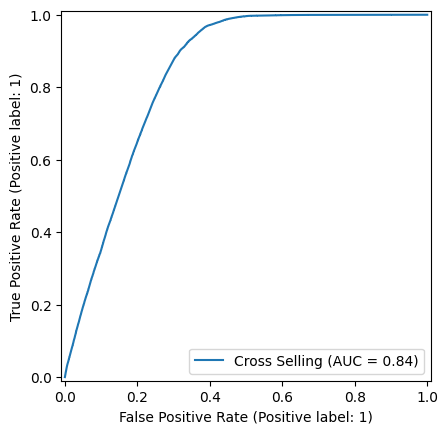


 REPORT METRICHE - TRAIN del modello ottimizzato con i seguenti parametri:
Penalty : l2 
 C = 0.0001
Soglia = 0.2 
 classweight: None 

              precision    recall  f1-score   support

           0       0.97      0.70      0.82    233813
           1       0.29      0.87      0.44     32775

    accuracy                           0.72    266588
   macro avg       0.63      0.79      0.63    266588
weighted avg       0.89      0.72      0.77    266588

-----------------------------------
Confusion Matrix Train


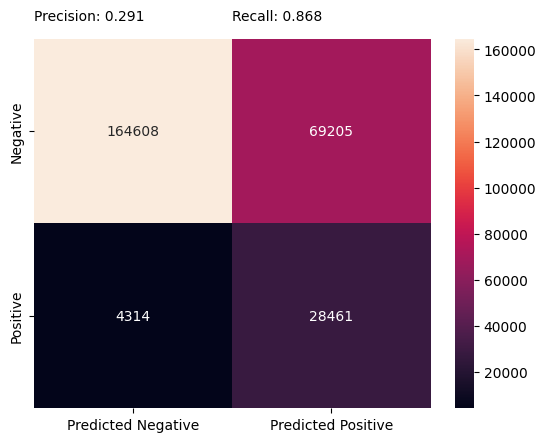

In [ ]:
model1 = LogisticRegressionPipeline(penalty='l2', C=1.0, class_weight = None)
model1.fit(X_train, y_train)

print('FINE TUNING DEGLI IPERPARAMETRI: SOGLIA E REGOLARIZZAZIONE')
model1.C, model1.threshold=model1.find_best_th_C(X_train, y_train, noprint=True)
print('-----------------------------------')
model1 = LogisticRegressionPipeline(model1.penalty, model1.C, model1.class_weight, model1.threshold)
model1.fit(X_train, y_train)

print('RISULTATI CROSS VALIDATION')
model1.cross_validation(X_train, y_train)
print('-----------------------------------')
print('ROC CURVE')
model1.plot_rocCurve(X_train, y_train)

print(f'\n REPORT METRICHE - TRAIN del modello ottimizzato con i seguenti parametri:')
print(model1.create_report(X_train, y_train))

print('-----------------------------------')
print('Confusion Matrix Train')
model1.plot_confusion_matrix(X_train, y_train, show_precisione_recall=True)


Dai risultati della cross-validation possiamo dire che il *modello 1* non soffre di overfitting. Con questo modello otteniamo un buon risultato per la **Recall** ma la precision rimane bassa. Questo modello sarà una baseline per poter giudicare gli altri.

### 2.3.B Utilizzo penalizzazione L1(model2)

FINE TUNING DEGLI IPERPARAMETRI: SOGLIA E REGOLARIZZAZIONE

 Valore più alto di f1 (0.44) 
 soglia: 0.2
C(inverso indice di regolarizzazione):0.001

-----------------------------------
RISULTATI CROSS VALIDATION
Medie e Deviazioni Standard delle Metriche:

Train Metrics:
  precision: Mean = 0.2900, Std = 0.0000

  recall: Mean = 0.8900, Std = 0.0000

  f1: Mean = 0.4300, Std = 0.0000


Test Metrics:
  precision: Mean = 0.2880, Std = 0.0040

  recall: Mean = 0.8880, Std = 0.0040

  f1: Mean = 0.4320, Std = 0.0040

-----------------------------------
ROC CURVE


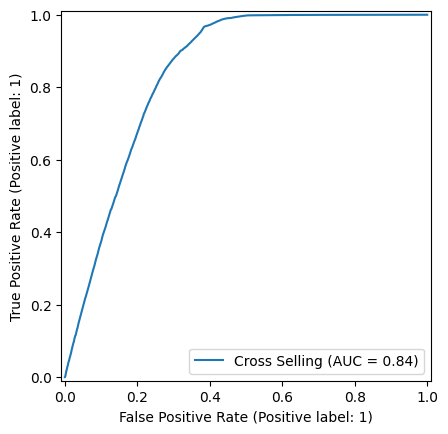


 REPORT METRICHE - TRAIN del modello ottimizzato con i seguenti parametri:
Penalty : l1 
 C = 0.001
Soglia = 0.2 
 classweight: None 

              precision    recall  f1-score   support

           0       0.98      0.70      0.81    233813
           1       0.29      0.88      0.44     32775

    accuracy                           0.72    266588
   macro avg       0.63      0.79      0.63    266588
weighted avg       0.89      0.72      0.77    266588

-----------------------------------
Confusion Matrix Train


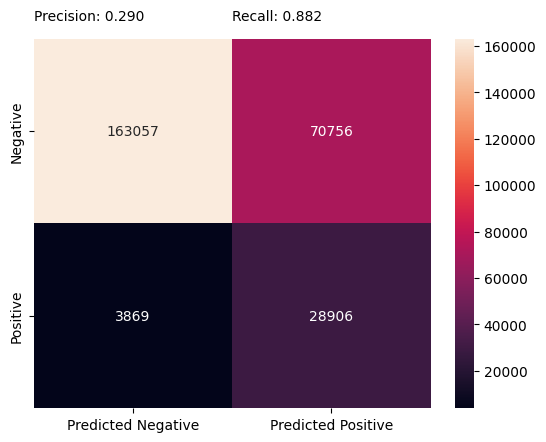

In [ ]:
model2 = LogisticRegressionPipeline(penalty='l1', C=1.0, class_weight = None)
model2.fit(X_train, y_train)

print('FINE TUNING DEGLI IPERPARAMETRI: SOGLIA E REGOLARIZZAZIONE')
model2.C, model2.threshold=model2.find_best_th_C(X_train, y_train, noprint=True)
print('-----------------------------------')
model2 = LogisticRegressionPipeline(model2.penalty, model2.C, model2.class_weight, model2.threshold)
model2.fit(X_train, y_train)

print('RISULTATI CROSS VALIDATION')
model2.cross_validation(X_train, y_train)
print('-----------------------------------')
print('ROC CURVE')
model2.plot_rocCurve(X_train, y_train)

print(f'\n REPORT METRICHE - TRAIN del modello ottimizzato con i seguenti parametri:')
print(model2.create_report(X_train, y_train))

print('-----------------------------------')
print('Confusion Matrix Train')
model2.plot_confusion_matrix(X_train, y_train, show_precisione_recall=True)

Anche in questo caso il modello non soffre di overfitting. I due modelli hanno prestazioni molto simili, il secondo ha una Recall leggermente migliore. Inoltre visto che abbiamo creato delle variabili dummy sembra più adeguato usare la penalità **L1** capace di fare features selection.

## 2.4 Modelli con bilanciamento delle classi

### 2.4.A Class_weight = 'balanced'(model3)

Usiamo l'attributo class_weight = 'balanced' per tenerse conto che nel nostro dataset le classi in response sono fortemente sbilanciate (No = 88%, Si = 12%)

FINE TUNING DEGLI IPERPARAMETRI: SOGLIA E REGOLARIZZAZIONE

 Valore più alto di f1 (0.45) 
 soglia: 0.7
C(inverso indice di regolarizzazione):0.001

-----------------------------------
RISULTATI CROSS VALIDATION
Medie e Deviazioni Standard delle Metriche:

Train Metrics:
  precision: Mean = 0.3200, Std = 0.0000

  recall: Mean = 0.7500, Std = 0.0000

  f1: Mean = 0.4480, Std = 0.0040


Test Metrics:
  precision: Mean = 0.3160, Std = 0.0049

  recall: Mean = 0.7520, Std = 0.0075

  f1: Mean = 0.4440, Std = 0.0049

-----------------------------------
ROC CURVE


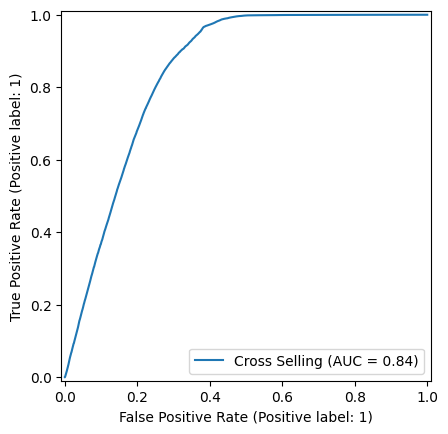


 REPORT METRICHE - TRAIN del modello ottimizzato con i seguenti parametri:
Penalty : l1 
 C = 0.001
Soglia = 0.7 
 classweight: balanced 

              precision    recall  f1-score   support

           0       0.96      0.78      0.86    233813
           1       0.32      0.74      0.45     32775

    accuracy                           0.77    266588
   macro avg       0.64      0.76      0.65    266588
weighted avg       0.88      0.77      0.81    266588

-----------------------------------
Confusion Matrix Train


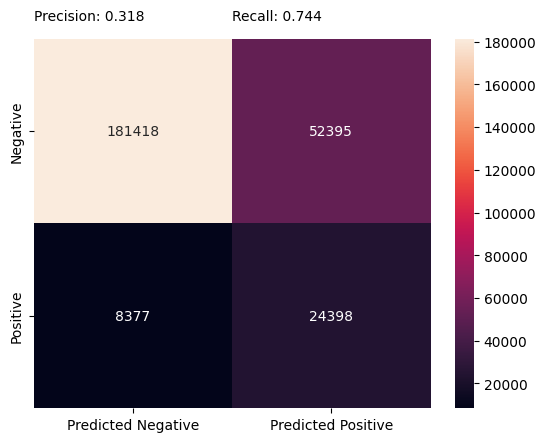

In [ ]:
model3 = LogisticRegressionPipeline(penalty='l1', C=1.0, class_weight = 'balanced')
model3.fit(X_train, y_train)
print('FINE TUNING DEGLI IPERPARAMETRI: SOGLIA E REGOLARIZZAZIONE')
model3.C, model3.threshold=model3.find_best_th_C(X_train, y_train, noprint=True)
print('-----------------------------------')

model3 = LogisticRegressionPipeline(model3.penalty, model3.C, model3.class_weight, model3.threshold)
model3.fit(X_train, y_train)

print('RISULTATI CROSS VALIDATION')
model3.cross_validation(X_train, y_train)
print('-----------------------------------')
print('ROC CURVE')
model3.plot_rocCurve(X_train, y_train)

print(f'\n REPORT METRICHE - TRAIN del modello ottimizzato con i seguenti parametri:')
print(model3.create_report(X_train, y_train))

print('-----------------------------------')
print('Confusion Matrix Train')
model3.plot_confusion_matrix(X_train, y_train, show_precisione_recall=True)

Anche in questo caso non abbiamo presenza di overfitting ma la Recall è peggiorata rispetto ai modelli precedenti.

###2.4.B Smote(model4)

FINE TUNING DEGLI IPERPARAMETRI: SOGLIA E REGOLARIZZAZIONE

 Valore più alto di f1 (0.82) 
 soglia: 0.4
C(inverso indice di regolarizzazione):0.0001

-----------------------------------
RISULTATI CROSS VALIDATION
Medie e Deviazioni Standard delle Metriche:

Train Metrics:
  precision: Mean = 0.7040, Std = 0.0049

  recall: Mean = 0.9800, Std = 0.0000

  f1: Mean = 0.8200, Std = 0.0000


Test Metrics:
  precision: Mean = 0.7040, Std = 0.0049

  recall: Mean = 0.9800, Std = 0.0000

  f1: Mean = 0.8200, Std = 0.0000

-----------------------------------
ROC CURVE


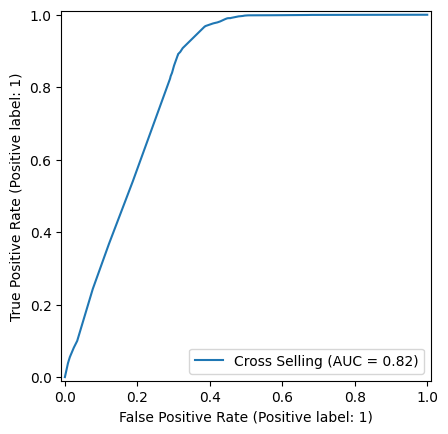


 REPORT METRICHE - TRAIN del modello ottimizzato con i seguenti parametri:
Penalty : l1 
 C = 0.0001
Soglia = 0.4 
 classweight: None 

              precision    recall  f1-score   support

           0       0.99      0.59      0.74    233813
           1       0.25      0.98      0.40     32775

    accuracy                           0.64    266588
   macro avg       0.62      0.78      0.57    266588
weighted avg       0.90      0.64      0.70    266588

-----------------------------------
Confusion Matrix Train


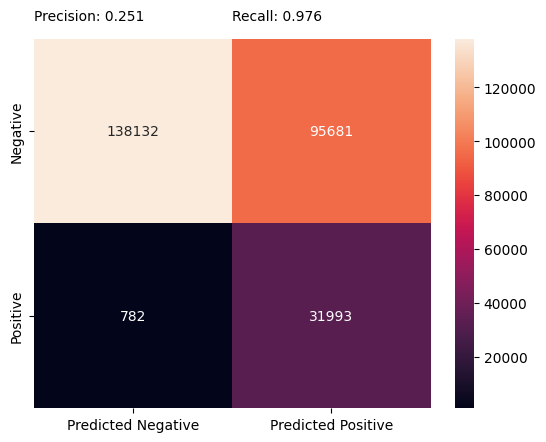

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

model4 = LogisticRegressionPipeline(penalty='l1', C=1.0, class_weight = None)
model4.fit(X_train_sm, y_train_sm)
print('FINE TUNING DEGLI IPERPARAMETRI: SOGLIA E REGOLARIZZAZIONE')
model4.C, model4.threshold=model4.find_best_th_C(X_train_sm, y_train_sm, noprint=True)
print('-----------------------------------')

model4 = LogisticRegressionPipeline(model4.penalty, model4.C, model4.class_weight, model4.threshold)
model4.fit(X_train_sm, y_train_sm)

print('RISULTATI CROSS VALIDATION')
model4.cross_validation(X_train_sm, y_train_sm)
print('-----------------------------------')
print('ROC CURVE')
model4.plot_rocCurve(X_train, y_train)

print(f'\n REPORT METRICHE - TRAIN del modello ottimizzato con i seguenti parametri:')
print(model4.create_report(X_train, y_train))

print('-----------------------------------')
print('Confusion Matrix Train')
model4.plot_confusion_matrix(X_train, y_train, show_precisione_recall=True)

Il modello non soffre di overfitting. La differenza tra i risultati della cv e delle metriche sono dovuti ai dataseti usati, per la cv dovendo rieseguire il fit del modello usiamo i dati bilanciati, mentre per il calcolo delle metriche quelli originali. Possiamo notare come si aumentato significativamente il valore della **Recall**, abbiamo ottenuto quasi un 10% perdendo un 4% di **Precision rispetto al modello 2.

### 2.4.C Oversampling(model5)

FINE TUNING DEGLI IPERPARAMETRI: SOGLIA E REGOLARIZZAZIONE

 Valore più alto di f1 (0.82) 
 soglia: 0.4
C(inverso indice di regolarizzazione):0.0001

-----------------------------------
RISULTATI CROSS VALIDATION
Medie e Deviazioni Standard delle Metriche:

Train Metrics:
  precision: Mean = 0.7020, Std = 0.0040

  recall: Mean = 0.9800, Std = 0.0000

  f1: Mean = 0.8200, Std = 0.0000


Test Metrics:
  precision: Mean = 0.7040, Std = 0.0049

  recall: Mean = 0.9800, Std = 0.0000

  f1: Mean = 0.8200, Std = 0.0000

-----------------------------------
ROC CURVE


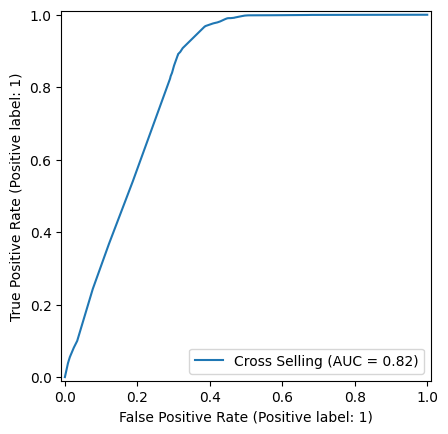


 REPORT METRICHE - TRAIN del modello ottimizzato con i seguenti parametri:
Penalty : l1 
 C = 0.0001
Soglia = 0.4 
 classweight: None 

              precision    recall  f1-score   support

           0       0.99      0.59      0.74    233813
           1       0.25      0.98      0.40     32775

    accuracy                           0.64    266588
   macro avg       0.62      0.78      0.57    266588
weighted avg       0.90      0.64      0.70    266588

-----------------------------------
Confusion Matrix Train


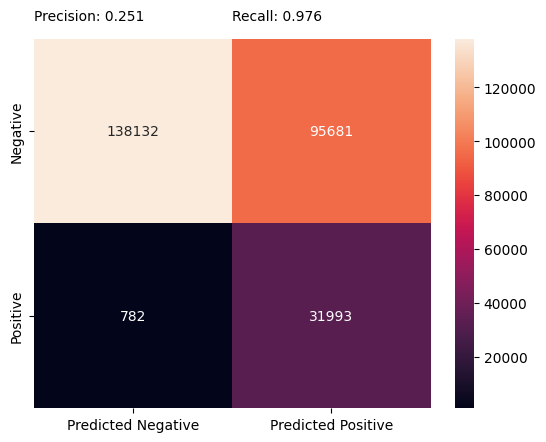

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_ov, y_train_ov = oversampler.fit_resample(X_train, y_train)

model5 = LogisticRegressionPipeline(penalty='l1', C=1.0, class_weight = None)
model5.fit(X_train_ov, y_train_ov)
print('FINE TUNING DEGLI IPERPARAMETRI: SOGLIA E REGOLARIZZAZIONE')
model5.C, model5.threshold=model5.find_best_th_C(X_train_ov, y_train_ov, noprint=True)
print('-----------------------------------')

model5 = LogisticRegressionPipeline(model5.penalty, model5.C, model5.class_weight, model5.threshold)
model5.fit(X_train_ov, y_train_ov)

print('RISULTATI CROSS VALIDATION')
model5.cross_validation(X_train_ov, y_train_ov)
print('-----------------------------------')
print('ROC CURVE')
model5.plot_rocCurve(X_train, y_train)

print(f'\n REPORT METRICHE - TRAIN del modello ottimizzato con i seguenti parametri:')
print(model5.create_report(X_train, y_train))

print('-----------------------------------')
print('Confusion Matrix Train')
model5.plot_confusion_matrix(X_train, y_train, show_precisione_recall=True)

Questo modello con oversampling si comporta esattamente come quello in cui abbiamo usato SMOTE.

### 2.4.D Undersampling(model6)

FINE TUNING DEGLI IPERPARAMETRI: SOGLIA E REGOLARIZZAZIONE

 Valore più alto di f1 (0.82) 
 soglia: 0.5
C(inverso indice di regolarizzazione):0.0001

-----------------------------------
RISULTATI CROSS VALIDATION
Medie e Deviazioni Standard delle Metriche:

Train Metrics:
  precision: Mean = 0.7000, Std = 0.0000

  recall: Mean = 0.9800, Std = 0.0000

  f1: Mean = 0.8200, Std = 0.0000


Test Metrics:
  precision: Mean = 0.7020, Std = 0.0040

  recall: Mean = 0.9760, Std = 0.0049

  f1: Mean = 0.8180, Std = 0.0040

-----------------------------------
ROC CURVE


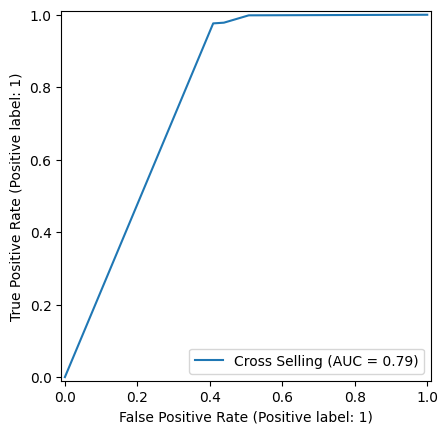


 REPORT METRICHE - TRAIN del modello ottimizzato con i seguenti parametri:
Penalty : l1 
 C = 0.0001
Soglia = 0.5 
 classweight: None 

              precision    recall  f1-score   support

           0       0.99      0.59      0.74    233813
           1       0.25      0.98      0.40     32775

    accuracy                           0.64    266588
   macro avg       0.62      0.78      0.57    266588
weighted avg       0.90      0.64      0.70    266588

-----------------------------------
Confusion Matrix Train


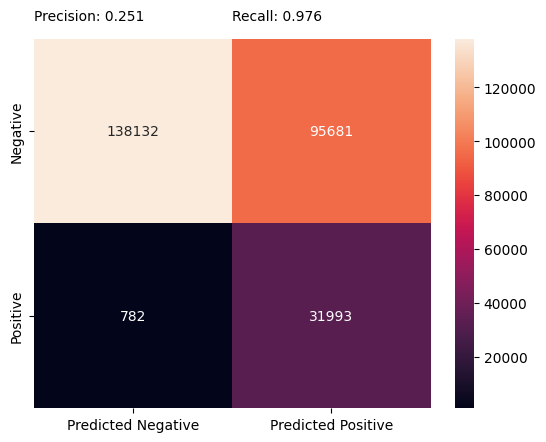

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_un, y_train_un = undersampler.fit_resample(X_train, y_train)

model6 = LogisticRegressionPipeline(penalty='l1', C=1.0, class_weight = None)
model6.fit(X_train_un, y_train_un)
print('FINE TUNING DEGLI IPERPARAMETRI: SOGLIA E REGOLARIZZAZIONE')
model6.C, model6.threshold=model6.find_best_th_C(X_train_un, y_train_un, noprint=True)
print('-----------------------------------')

model6 = LogisticRegressionPipeline(model6.penalty, model6.C, model6.class_weight, model6.threshold)
model6.fit(X_train_un, y_train_un)

print('RISULTATI CROSS VALIDATION')
model6.cross_validation(X_train_un, y_train_un)
print('-----------------------------------')
print('ROC CURVE')
model6.plot_rocCurve(X_train, y_train)

print(f'\n REPORT METRICHE - TRAIN del modello ottimizzato con i seguenti parametri:')
print(model6.create_report(X_train, y_train))

print('-----------------------------------')
print('Confusion Matrix Train')
model6.plot_confusion_matrix(X_train, y_train, show_precisione_recall=True)

Nessun modello soffe di overfitting, questo vuol dire che sarebbero tutti in grado di generalizzare senza peggiorare le loro prestazioni.

I modelli 4, 5 e 6 sono quelli che hanno le metriche migliori per quanto riguarda Precision e Recall, ottenendo esattamente gli stessi valori predilegiamo il modello 6 (undersampling) in quanto non introduce samples artificiali che potrebbero portare ad overfitting quando applicheremo il modello su dati non visti.

## 2.5 Trasformazione di potenza **Annual_Premium**

Siamo interessati a vedere se le prestazioni del nostro modello cambiano applicando una trasformazione di potenza all'**Annual_Premium** che ha una distribuzione con una coda molto estesa.

In [ ]:
from sklearn.preprocessing import PowerTransformer
power = PowerTransformer(method='box-cox', standardize=True)
df_power = df_pr.copy()
df_power['Annual_Premium'] = power.fit_transform(df[['Annual_Premium']])

### 2.5.A Trainining modello 6

In [ ]:
X_pw = df_power.drop(['Response', 'Vintage'], axis=1).values
y_pw = df_power["Response"].values

X_train_pw, X_test_pw, y_train_pw, y_test_pw = train_test_split(X_pw, y_pw, test_size=.3, random_state=RANDOM_SEED)
ss = StandardScaler()
X_train_pw = ss.fit_transform(X_train_pw)
X_test_pw = ss.transform(X_test_pw)

FINE TUNING DEGLI IPERPARAMETRI: SOGLIA E REGOLARIZZAZIONE

 Valore più alto di f1 (0.82) 
 soglia: 0.5
C(inverso indice di regolarizzazione):0.0001

-----------------------------------
RISULTATI CROSS VALIDATION
Medie e Deviazioni Standard delle Metriche:

Train Metrics:
  precision: Mean = 0.7000, Std = 0.0000

  recall: Mean = 0.9800, Std = 0.0000

  f1: Mean = 0.8200, Std = 0.0000


Test Metrics:
  precision: Mean = 0.7020, Std = 0.0040

  recall: Mean = 0.9760, Std = 0.0049

  f1: Mean = 0.8180, Std = 0.0040

-----------------------------------
ROC CURVE


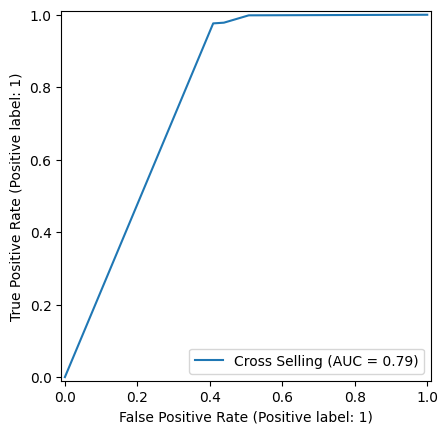


 REPORT METRICHE - TRAIN del modello ottimizzato con i seguenti parametri:
Penalty : l1 
 C = 0.0001
Soglia = 0.5 
 classweight: None 

              precision    recall  f1-score   support

           0       0.99      0.59      0.74    233813
           1       0.25      0.98      0.40     32775

    accuracy                           0.64    266588
   macro avg       0.62      0.78      0.57    266588
weighted avg       0.90      0.64      0.70    266588

-----------------------------------
Confusion Matrix Train


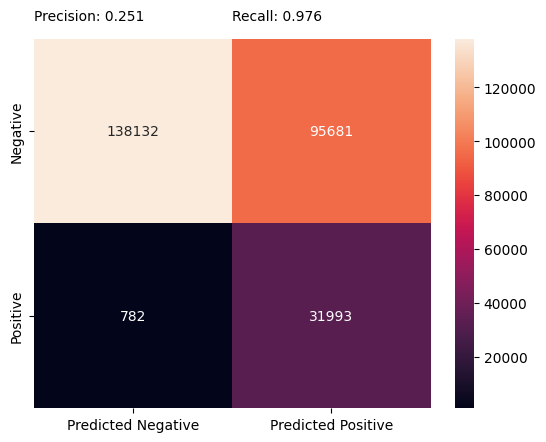

In [ ]:
undersampler = RandomUnderSampler(random_state=42)
X_train_pw_u, y_train_pw_u = undersampler.fit_resample(X_train_pw, y_train_pw)

model6b = LogisticRegressionPipeline(penalty='l1', C=1.0, class_weight = None)
model6b.fit(X_train_pw_u, y_train_pw_u)
print('FINE TUNING DEGLI IPERPARAMETRI: SOGLIA E REGOLARIZZAZIONE')
model6b.C, model6b.threshold=model6b.find_best_th_C(X_train_pw_u, y_train_pw_u, noprint=True)
print('-----------------------------------')

model6b = LogisticRegressionPipeline(model6b.penalty, model6b.C, model6b.class_weight, model6b.threshold)
model6b.fit(X_train_pw_u, y_train_pw_u)

print('RISULTATI CROSS VALIDATION')
model6b.cross_validation(X_train_pw_u, y_train_pw_u)
print('-----------------------------------')
print('ROC CURVE')
model6b.plot_rocCurve(X_train_pw, y_train_pw)

print(f'\n REPORT METRICHE - TRAIN del modello ottimizzato con i seguenti parametri:')
print(model6b.create_report(X_train_pw, y_train_pw))

print('-----------------------------------')
print('Confusion Matrix Train')
model6b.plot_confusion_matrix(X_train_pw, y_train_pw, show_precisione_recall=True)

Non osserviamo nessun cambiamento nelle metriche del modello, quindi la trasformazione su **Annula_Premium** non sembra avere alcuna influenza sulle capacità di previsione del nostro modello.

# 3 Valutazione del modello scelto sull'intero dataset


Confusion Matrix Test Modello 6


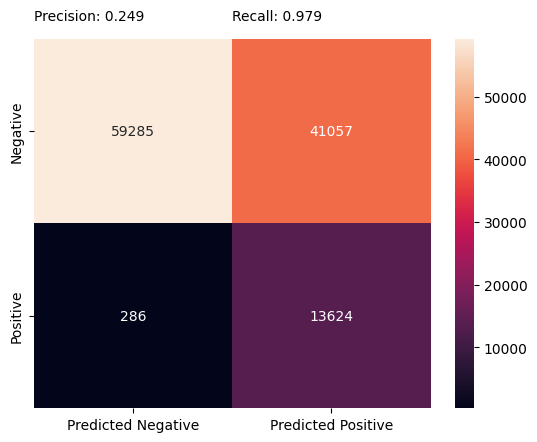

In [ ]:
print('Confusion Matrix Test Modello 6')
model6.plot_confusion_matrix(X_test, y_test, show_precisione_recall=True)

Confusion Matrix Modello 6: Intero dataset


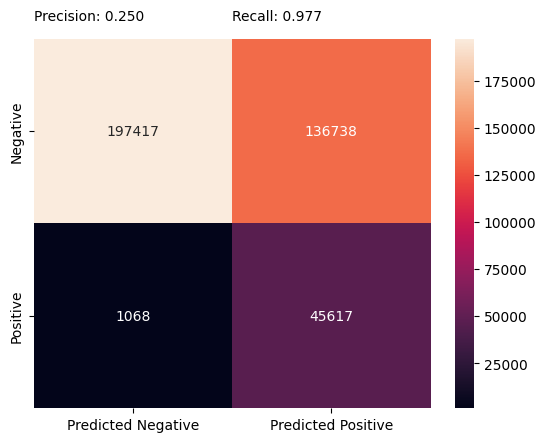

In [ ]:
print('Confusion Matrix Modello 6: Intero dataset')
model6.plot_confusion_matrix(X, y, show_precisione_recall=True)

Testando il modello su tutto il dataset vediamo che mantiene le stesse metriche sia sul dataset di test che su tutto il dataset. Ulteriore conferma che il modello non soffre di overfitting.



#4 Commenti e interpretazione del modello

Stampiamo i valori dei parametri del nostro modello e mettiamole in relazione con le colonne del dataset.

In [ ]:
print(f'Intercetta: {model6.model.intercept_[0]:.2f}')
column_names = list(df_pr.columns)
column_names.remove('Vintage')
column_names.remove('Response')
for i, col in enumerate(column_names):
  print(f'{col}: {model6.model.coef_[0][i]:.4f}')

Intercetta: -0.27
Gender: 0.0000
Age: 0.0000
Driving_License: 0.0000
Previously_Insured: -0.2098
Vehicle_Age: 0.0000
Vehicle_Damage: 0.4131
Annual_Premium: 0.0000
Channel_26.0: 0.0000
Channel_124.0: 0.0000
Channel_152.0: 0.0000
Channel_160.0: 0.0000
Channel_Rare: 0.0000
Code_8.0: 0.0000
Code_28.0: 0.0000
Code_46.0: 0.0000
Code_Rare: 0.0000


Vediamo che le due feature che vengono usate dal modello solo solamente:
- Previously_Insured con un coefficiente di -0.21, vuol dire che se qualcuno ha già contratto la polizza ha in media una probabilità più bassa del 21% di acquistare la polizza.
- Vehicle_Damage che ci dice che in media chi ha subito un dato ha una probabilità del 41% di contrarre la polizza.

Considerando la forte asimmetria delle classi il nostro modello riesce a prevedere i veri positivi con una Recall di circa il 98%, i falsi negativi sono circa 1/6 del totale dei positivi. Questo risultato è stato ottenuto a discapito della precision (falsi positivi) che è di solo il 25%, però per come è stato allenato il modello questo sono i valori che massimizzano la metrica F1 che è una media delle altre due.

In conclusione possiamo dire che per raggiungere nuovi clienti sarà fondamentale guardare i dati relativi alle precedenti assicurazioni e se il cliente ha già subito dei danni.